Loaded 99422 rows with 50 columns.
Found 97 players with at least 100 games.
Selected features: ['great_count', 'opening_accuracy', 'opening_novelty_score', 'material_changes', 'space_advantage', 'player_elo', 'top2_3_move_alignment', 'center_control_avg', 'sacrifice_count', 'top_move_alignment', 'good_moves', 'endgame_length', 'minor_piece_development', 'prophylactic_frequency', 'piece_mobility_avg']
PCA explained variance ratios: [0.35036452 0.29953083 0.10617579]


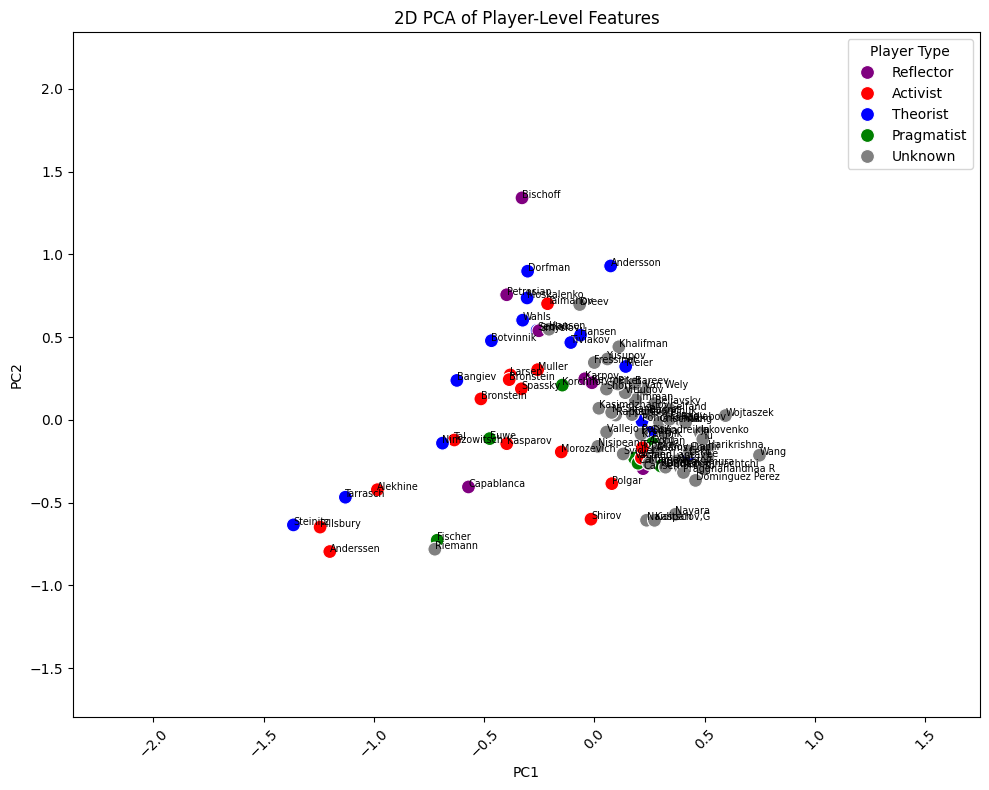

PCA (all features) explained variance ratios: [0.34711189 0.27951698 0.08767232]


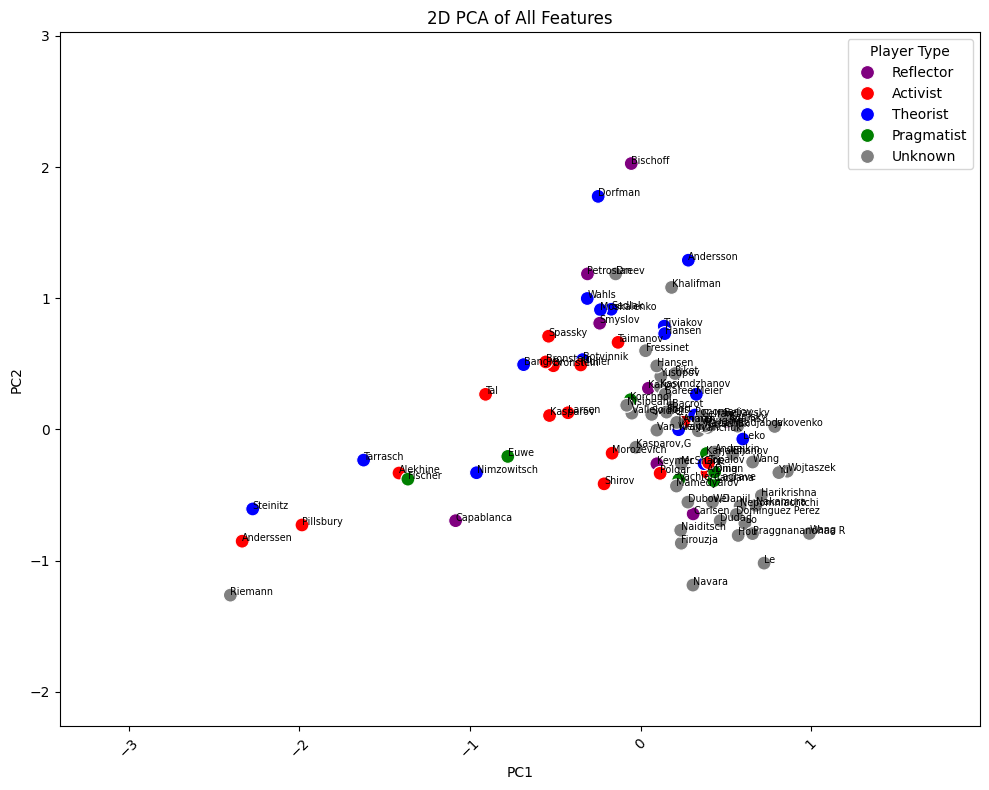

Mean AUC Score (Decision Boundary Score): 0.6776869692036358


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]

    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player]
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown' # Changed None to 'Unknown'
        else:
            p_type = 'Unknown' # Changed None to 'Unknown'

        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        # Compute averages for each numeric feature
        for col in numeric_cols:
            player_stats[col] = player_games[col].mean()
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    return agg_df

# -------------------------------
# Step 2. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']

    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=2500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("Selected features:", selected)
    return selected

# -------------------------------
# Step 3. Apply PCA to Selected Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3):
    """
    Scale the selected features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

def apply_pca_all_features(agg_df, n_components=2):
    """
    Apply PCA to all numeric features (without any feature selection)
    for a 2D visualization.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns 
                    if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    
    X = agg_df[numeric_cols]
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)
    
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA (all features) explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

# -------------------------------
# Step 4. Visualize 2D PCA Result using Seaborn
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d, title='2D PCA of Player-Level Features'):
    """
    Visualize 2D PCA result using a scatter plot.
    Points are colored by player_type and labeled by player_name.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })

    plt.figure(figsize=(10, 8))
    # Define the palette, using 'Unknown' as the key for gray
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray' # Changed None key to 'Unknown'
    }
    ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100)

    # Add labels for each point
    for line in range(0,pca_df.shape[0]):
         player_name = pca_df.player_name[line]
         if ', ' in player_name:
             last_name = player_name.split(', ')[0]
             ax.text(pca_df.PC1[line], pca_df.PC2[line], last_name, horizontalalignment='left', size='x-small', color='black')
         else:
             ax.text(pca_df.PC1[line], pca_df.PC2[line], player_name, horizontalalignment='left', size='x-small', color='black')

    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Player Type')
    plt.xlim(X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1)
    plt.ylim(X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 5. Create Interactive 3D PCA Visualization using Plotly Express
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d):
    """
    Create an interactive 3D scatter plot of the PCA result using Plotly Express.
    Points are colored by player_type.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })

    # Define the color map, using 'Unknown' as the key for gray
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'  # Changed None key to 'Unknown'
    }

    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        hover_data=['player_name'],
        color_discrete_map=color_map,
        title='Interactive 3D PCA of Player-Level Features'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 6. Decision Boundary Score (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df):
    """
    Calculates the Area Under the ROC Curve (AUC) for a RandomForestClassifier
    predicting player_type.  Uses the selected features from the
    select_best_features function.
    """

    # Prepare data
    agg_df = agg_df.copy()
    le = LabelEncoder()
    agg_df['player_type'] = le.fit_transform(agg_df['player_type'])  # Numerical labels

    # Select features (using the same logic as before)
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']

    # Impute and Scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=2500, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = rf_classifier.predict_proba(X_test)

    # Calculate AUC (one-vs-rest for multiclass)
    auc_scores = []
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            auc_scores.append(auc)
        except ValueError as e:
            print(f"ValueError calculating AUC for class {le.classes_[i]}: {e}")
            auc_scores.append(0.5)  # Assign a neutral value if AUC cannot be computed

    mean_auc = np.mean(auc_scores)

    print(f"Mean AUC Score (Decision Boundary Score): {mean_auc}")
    return mean_auc


# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'  # Adjust the file path as necessary
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")

    # Aggregate to player level (using a minimum game threshold, e.g., 100)
    # This will now replace None player_types with 'Unknown'
    agg_df = aggregate_player_data(df, min_games=100)

    # Select best features based on importance
    selected_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA for 3 components
    X_pca, pca_model = apply_pca(agg_df, selected_features, n_components=3)

    # Visualize the first 2 components (2D PCA)
    # The palette now correctly maps 'Unknown' to gray
    visualize_2d_pca(agg_df, X_pca[:, :2])

    # Create an interactive 3D PCA visualization
    # The color map now correctly maps 'Unknown' to gray
    visualize_3d_pca(agg_df, X_pca)
    
    
    # apply PCA to all features for 2D visualization
    X_pca_all, pca_model_all = apply_pca_all_features(agg_df, n_components=3)
    visualize_2d_pca(agg_df, X_pca_all[:, :2], title='2D PCA of All Features')
    # Create an interactive 3D PCA visualization for all features
    visualize_3d_pca(agg_df, X_pca_all)

    # Calculate and print decision boundary score (AUC)
    calculate_decision_boundary_score(agg_df)

if __name__ == "__main__":
    main()


In [ ]:
70733745037505244

Loaded 99422 rows with 50 columns.
Found 97 players with at least 100 games.

Assigned player types for 2 players from provided lists
Assigned eras for 49 players

Player Era Categorization:
  Unknown Era: 48 players
  Computer Age: 31 players
  Pre-Computer Age: 18 players

Player Types in Computer Age:
  Theorist: 14 players
  Activist: 8 players
  Reflector: 5 players
  Pragmatist: 4 players

Player Types in Pre-Computer Age:
  Activist: 8 players
  Theorist: 4 players
  Pragmatist: 3 players
  Reflector: 3 players

Player Types in Unknown Era:
  Unknown: 46 players
  Activist: 2 players

Selected features: ['great_count', 'opening_accuracy', 'opening_novelty_score', 'material_changes', 'player_elo', 'minor_piece_development', 'space_advantage', 'sacrifice_count', 'center_control_avg', 'top2_3_move_alignment', 'top_move_alignment', 'check_frequency', 'endgame_length', 'pawn_exchange_rate', 'pawn_structure_changes']
PCA explained variance ratios: [0.37062517 0.29592112 0.10945318]


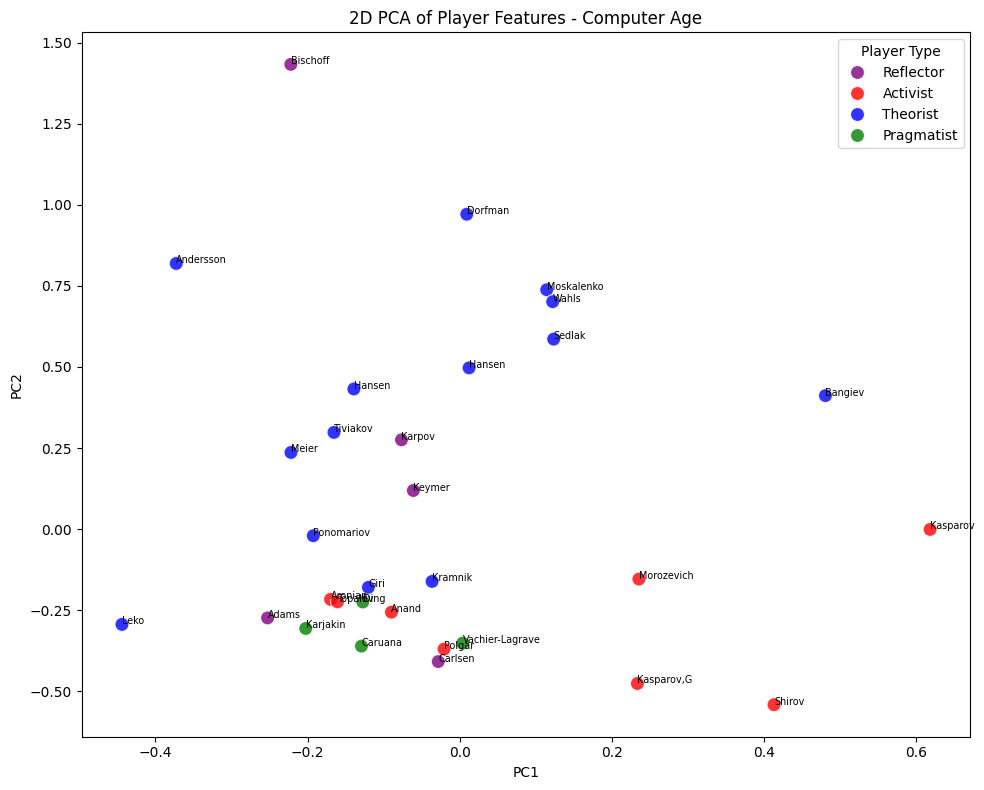

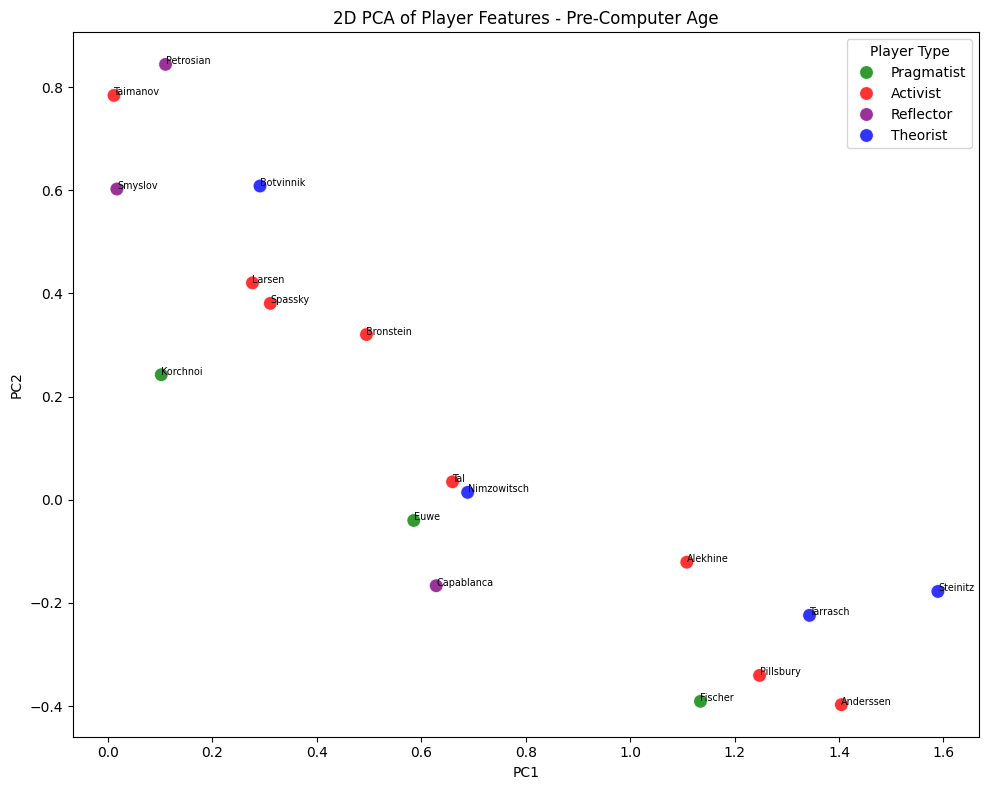

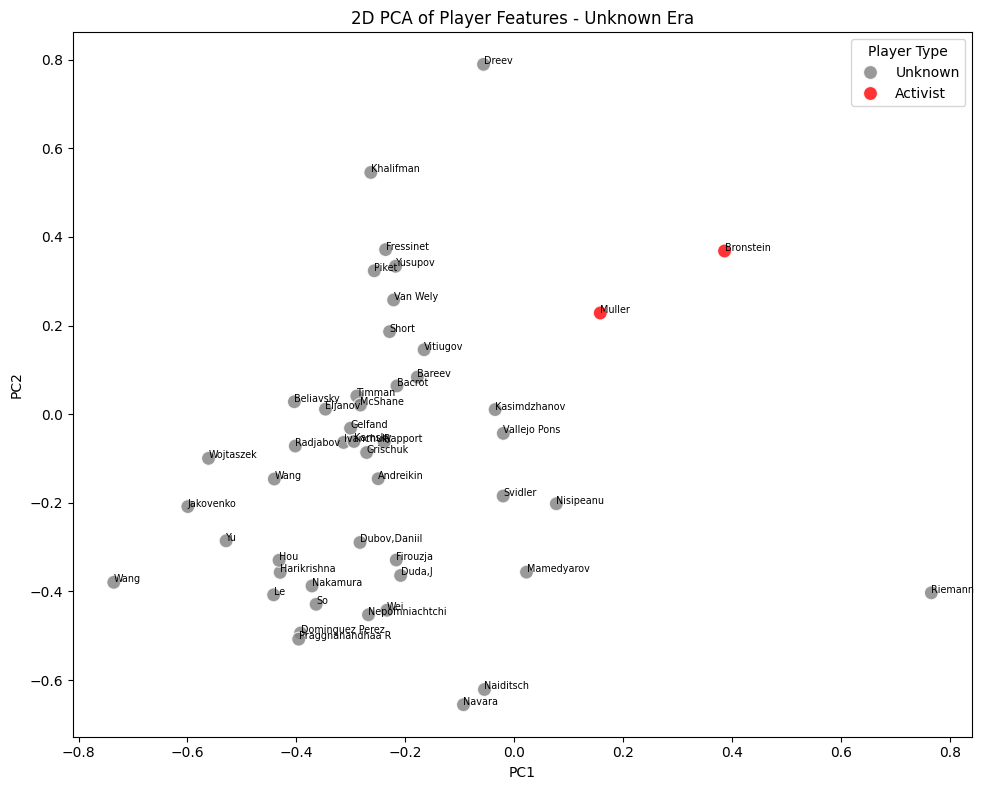

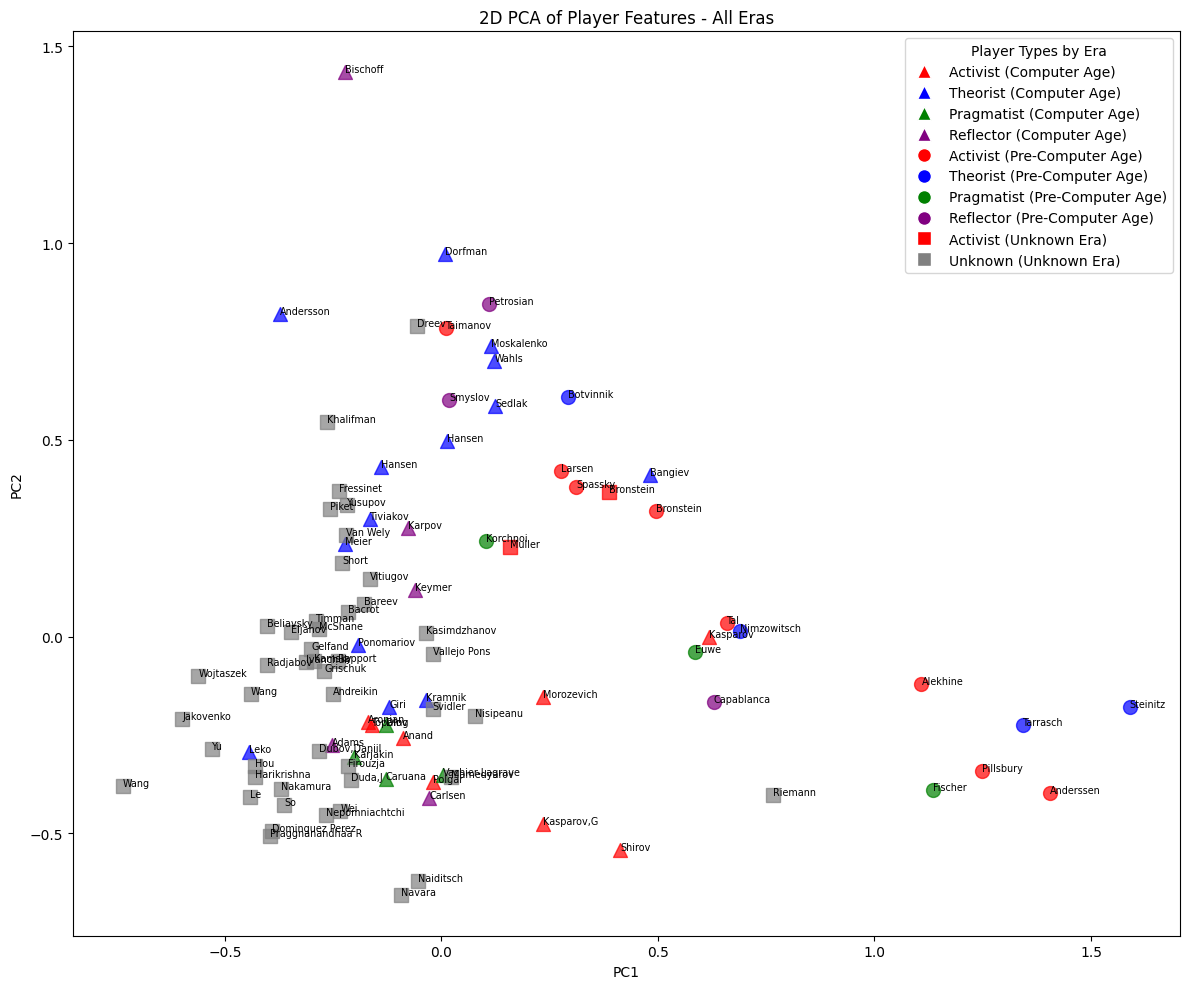


Calculating Decision Boundary Score for Computer Age:
  AUC for Activist: 0.8810
  AUC for Pragmatist: 0.4444
  AUC for Reflector: 0.5938
  AUC for Theorist: 0.7708
  Mean AUC Score for Computer Age: 0.6725

Calculating Decision Boundary Score for Pre-Computer Age:
  AUC for Activist: 0.2778
  AUC for Pragmatist: 0.4000
  AUC for Reflector: 1.0000
  AUC for Theorist: 0.6000
  Mean AUC Score for Pre-Computer Age: 0.5694

Calculating Decision Boundary Score for Unknown Era:
  AUC for Activist: 1.0000
  AUC for Unknown: 1.0000
  Mean AUC Score for Unknown Era: 1.0000

Calculating Combined Decision Boundary Score:
  AUC for Activist: 0.8090
  AUC for Pragmatist: 0.1696
  AUC for Reflector: 0.5357
  AUC for Theorist: 0.6146
  AUC for Unknown: 0.9464
Combined Mean AUC Score: 0.6151


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Define Known Player Types by Era
# -------------------------------
activist_pre_computer = [
    "Alekhine", "Tal", "Spassky", "Pillsbury",
    "Anderssen", "Bronstein, David", "Larsen", "Taimanov"
]

activist_computer_age = [
    "Kasparov", "Anand", "Shirov", "Morozevich",
    "Topalov", "Aronian", "Polgar", "Müller"
]

theorist_pre_computer = [
    "Steinitz", "Botvinnik", "Tarrasch", "Nimzowitsch"
]

theorist_computer_age = [
    "Kramnik", "Leko", "Giri", "Meier", "Andersson",
    "Sedlak", "Tiviakov", "Ponomariov", "Wahls",
    "Moskalenko", "Dorfman", "Bangiev", "Hansen"
]

reflector_pre_computer = [
    "Capablanca", "Smyslov", "Petrosian"
]

reflector_computer_age = [
    "Karpov", "Carlsen", "Adams", "Keymer", "Bischoff"
]

pragmatist_pre_computer = [
    "Fischer", "Euwe", "Korchnoi"
]

pragmatist_computer_age = [
    "Caruana", "Ding", "Karjakin", "Vachier-Lagrave"
]

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]

    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player]
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
        else:
            p_type = 'Unknown'

        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        # Compute averages for each numeric feature
        for col in numeric_cols:
            player_stats[col] = player_games[col].mean()
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    return agg_df

# -------------------------------
# Step 2. Categorize Players into Pre-Computer and Computer Age Eras
# -------------------------------
def categorize_players_by_era(agg_df):
    """
    Categorize players into "Pre-Computer Age" and "Computer Age" based on
    their presence in the known player lists.
    """
    # Add era column, default to 'Unknown Era'
    agg_df['era'] = 'Unknown Era'
    
    # For tracking assignment stats
    assigned_type_count = 0
    assigned_era_count = 0
    
    # Categorize players by type and era
    for idx, player in agg_df.iterrows():
        player_name = player['player_name']
        original_type = player['player_type']
        
        # Check all known player categories
        if any(name in player_name for name in activist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in activist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_computer_age):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        else:
            # Try to extract birth/death years from player names if we didn't match a known player
            import re
            birth_year = None
            
            # Look for years in parentheses in the player name
            year_pattern = r'\((\d{4})[-–](\d{4}|\?{4}|\d{0})\)'
            match = re.search(year_pattern, player_name)
            
            if match:
                # Found birth-death years pattern
                birth_year = int(match.group(1))
                
                # Assume a player's prime playing years are ~20-30 years after birth
                prime_playing_year = birth_year + 30
                if prime_playing_year < 1990:  # 1990 as computer age threshold
                    agg_df.at[idx, 'era'] = 'Pre-Computer Age'
                    assigned_era_count += 1
                else:
                    agg_df.at[idx, 'era'] = 'Computer Age'
                    assigned_era_count += 1
    
    # Summary of the categorization
    print(f"\nAssigned player types for {assigned_type_count} players from provided lists")
    print(f"Assigned eras for {assigned_era_count} players")
    
    era_counts = agg_df['era'].value_counts()
    print("\nPlayer Era Categorization:")
    for era, count in era_counts.items():
        print(f"  {era}: {count} players")
    
    # Count player types in each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era]
        print(f"\nPlayer Types in {era}:")
        type_counts = era_df['player_type'].value_counts()
        for player_type, count in type_counts.items():
            print(f"  {player_type}: {count} players")
    
    return agg_df

# -------------------------------
# Step 3. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']

    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=1500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("\nSelected features:", selected)
    return selected

# -------------------------------
# Step 4. Apply PCA to Selected Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3):
    """
    Scale the selected features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

# -------------------------------
# Step 5. Visualize 2D PCA Result using Seaborn 
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d):
    """
    Visualize 2D PCA result with separate plots for each era, and a combined view.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color palette for player types
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }
    
    # Create separate plots for each era
    eras = pca_df['era'].unique()
    
    for era in eras:
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping visualization for {era} (insufficient data)")
            continue
            
        plt.figure(figsize=(10, 8))
        ax = sns.scatterplot(data=era_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100, alpha=0.8)

        # Add labels for each point
        for i, row in era_df.iterrows():
            player_name = row['player_name']
            if ', ' in player_name:
                last_name = player_name.split(', ')[0]
                ax.text(row['PC1'], row['PC2'], last_name, 
                       horizontalalignment='left', size='x-small', color='black')
            else:
                ax.text(row['PC1'], row['PC2'], player_name, 
                       horizontalalignment='left', size='x-small', color='black')

        plt.title(f'2D PCA of Player Features - {era}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Player Type')
        plt.tight_layout()
        plt.show()

    # Create combined visualization with different markers for each era
    plt.figure(figsize=(12, 10))
    
    # Define markers for eras
    markers = {'Pre-Computer Age': 'o', 'Computer Age': '^', 'Unknown Era': 's'}
    
    # Create a custom legend elements list
    from matplotlib.lines import Line2D
    legend_elements = []
    
    # Plot each era and player type combination separately
    for era in eras:
        for p_type in palette.keys():
            # Get the subset of data for this era and player type
            subset = pca_df[(pca_df['era'] == era) & (pca_df['player_type'] == p_type)]
            if not subset.empty:
                plt.scatter(subset['PC1'], subset['PC2'], 
                           color=palette[p_type], 
                           marker=markers[era],
                           s=100, 
                           alpha=0.7,
                           label=f"{p_type} ({era})")
                
                # Add this combination to the legend
                legend_elements.append(
                    Line2D([0], [0], marker=markers[era], color='w', 
                          markerfacecolor=palette[p_type], markersize=10, 
                          label=f"{p_type} ({era})")
                )
    
    # Add player name labels
    for i, row in pca_df.iterrows():
        player_name = row['player_name']
        if ', ' in player_name:
            last_name = player_name.split(', ')[0]
            plt.text(row['PC1'], row['PC2'], last_name, 
                   horizontalalignment='left', size='x-small', color='black')
        else:
            plt.text(row['PC1'], row['PC2'], player_name, 
                   horizontalalignment='left', size='x-small', color='black')
    
    plt.title('2D PCA of Player Features - All Eras')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles=legend_elements, loc='best', title="Player Types by Era")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 6. Create Interactive 3D PCA Visualization
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d):
    """
    Create interactive 3D scatter plots of the PCA result using Plotly Express.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color map for player types
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }

    # Create separate plots for each era
    for era in pca_df['era'].unique():
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping 3D visualization for {era} (insufficient data)")
            continue
        
        fig = px.scatter_3d(
            era_df,
            x='PC1', y='PC2', z='PC3',
            color='player_type',
            hover_data=['player_name', 'num_games'],
            color_discrete_map=color_map,
            title=f'3D PCA of Player Features - {era}'
        )
        fig.update_traces(marker=dict(size=5))
        fig.show()
    
    # Create a combined visualization with both color and symbol
    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        symbol='era',  # Use era for different marker symbols
        hover_data=['player_name', 'num_games', 'era'],
        color_discrete_map=color_map,
        title='3D PCA of Player Features - All Eras Combined'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 7. Calculate Decision Boundary Quality (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df):
    """
    Calculate the Area Under the ROC Curve (AUC) for predicting player_type.
    """
    # Calculate separately for each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era].copy()
        
        # Skip if too few samples or not enough player types
        if len(era_df) < 10 or era_df['player_type'].nunique() <= 1:
            print(f"Skipping AUC calculation for {era} (insufficient data)")
            continue
            
        print(f"\nCalculating Decision Boundary Score for {era}:")
        
        # Encode player types
        le = LabelEncoder()
        era_df['player_type'] = le.fit_transform(era_df['player_type'])
        
        # Define features
        metadata = ['player_name', 'player_type', 'num_games', 'era']
        numeric_cols = [col for col in era_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(era_df[col])]
        
        X = era_df[numeric_cols]
        y = era_df['player_type']
        
        # Prepare the data
        imputer = SimpleImputer(strategy='mean')
        scaler = MinMaxScaler()
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
        
        # Use stratified sampling to maintain class distribution
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.3, random_state=42, stratify=y
            )
            
            # Train RandomForest and get predictions
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            y_pred_proba = rf.predict_proba(X_test)
            
            # Calculate AUC for each class
            auc_scores = []
            for i in range(len(le.classes_)):
                if i < y_pred_proba.shape[1]:
                    try:
                        auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
                        class_name = le.inverse_transform([i])[0]
                        print(f"  AUC for {class_name}: {auc:.4f}")
                        auc_scores.append(auc)
                    except ValueError as e:
                        print(f"  Error calculating AUC for class {i}: {e}")
            
            if auc_scores:
                mean_auc = np.mean(auc_scores)
                print(f"  Mean AUC Score for {era}: {mean_auc:.4f}")
        
        except Exception as e:
            print(f"  Could not calculate AUC for {era}: {e}")
    
    # Calculate for all players combined
    print("\nCalculating Combined Decision Boundary Score:")
    
    # Prepare data
    agg_df_copy = agg_df.copy()
    le = LabelEncoder()
    agg_df_copy['player_type'] = le.fit_transform(agg_df_copy['player_type'])

    # Select features
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    numeric_cols = [col for col in agg_df_copy.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df_copy[col])]

    X = agg_df_copy[numeric_cols]
    y = agg_df_copy['player_type']

    # Process the data
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Train and evaluate
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)

    # Calculate AUC for each class
    auc_scores = []
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            class_name = le.inverse_transform([i])[0]
            print(f"  AUC for {class_name}: {auc:.4f}")
            auc_scores.append(auc)
        except ValueError as e:
            print(f"  Error for class {i}: {e}")

    if auc_scores:
        mean_auc = np.mean(auc_scores)
        print(f"Combined Mean AUC Score: {mean_auc:.4f}")

# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")

    # Aggregate to player level
    agg_df = aggregate_player_data(df, min_games=100)
    
    # Categorize players into eras
    agg_df = categorize_players_by_era(agg_df)

    # Select best features
    selected_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA
    X_pca, pca_model = apply_pca(agg_df, selected_features, n_components=3)

    # Visualize PCA results
    visualize_2d_pca(agg_df, X_pca[:, :2])
    visualize_3d_pca(agg_df, X_pca)

    # Calculate decision boundary quality
    calculate_decision_boundary_score(agg_df)

if __name__ == "__main__":
    main()

Loading and preparing data...
Original dataset shape: (99422, 50)

Player types in dataset:
player_type
NaN           45545
Theorist      17323
Activist      16266
Pragmatist    10319
Reflector      9969
Name: count, dtype: int64

Balancing dataset by sampling 9969 games from each player type
Balanced dataset shape: (39876, 50)
player_type
Activist      9969
Reflector     9969
Pragmatist    9969
Theorist      9969
Name: count, dtype: int64

Performing feature engineering...
Base features: 40
Creating composite features...
Total features after engineering: 45

Preparing data for analysis...
Player type mapping: {'Activist': 0, 'Pragmatist': 1, 'Reflector': 2, 'Theorist': 3}

Performing feature selection...

Top discriminative features:
1. theoretical_adherence: 126.92
2. space_advantage: 106.71
3. opening_novelty_score: 99.67
4. top_move_alignment: 98.81
5. opening_length: 79.23
6. opening_accuracy: 74.29
7. good_moves: 67.84
8. material_changes: 65.84
9. total_moves: 61.51
10. material

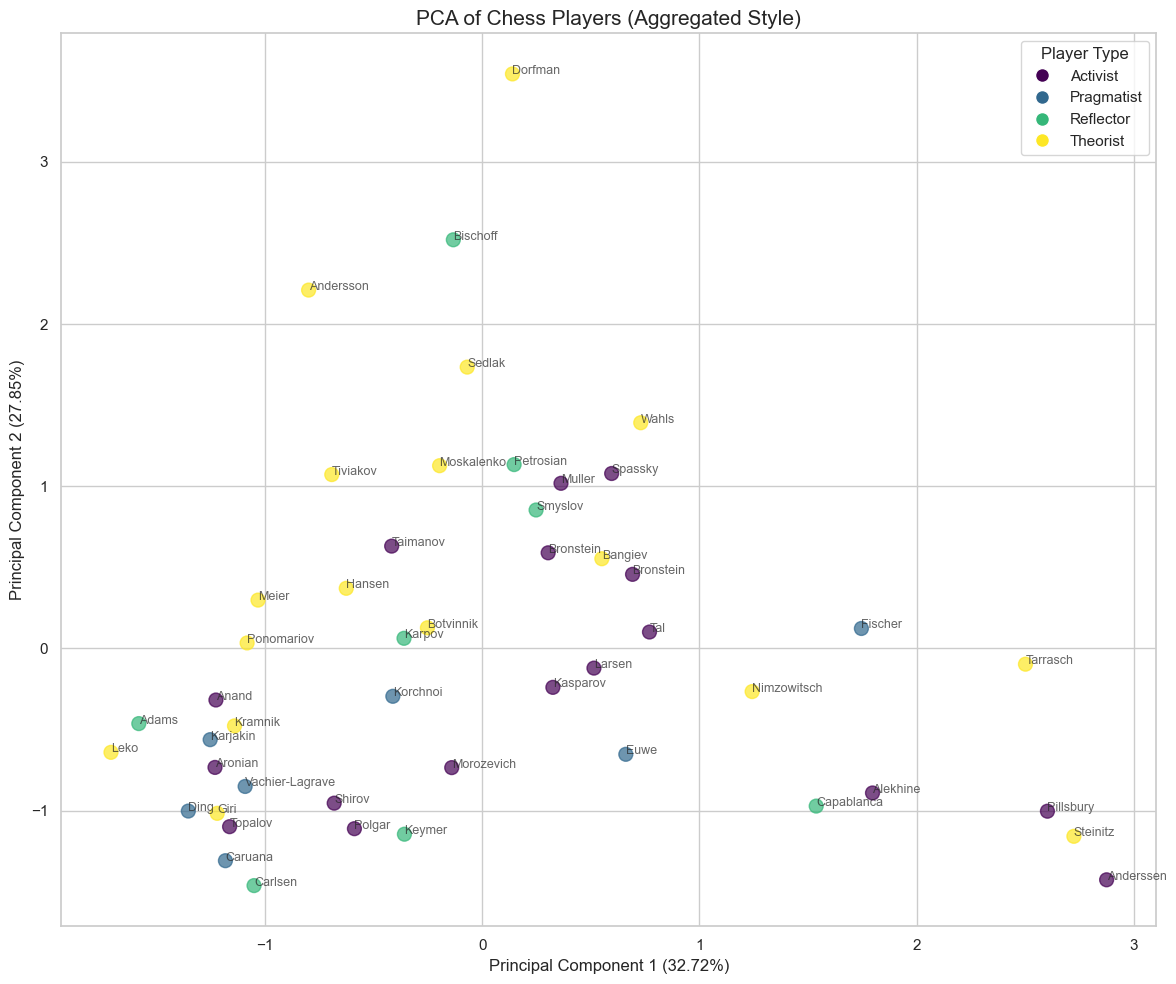


Creating visualizations...


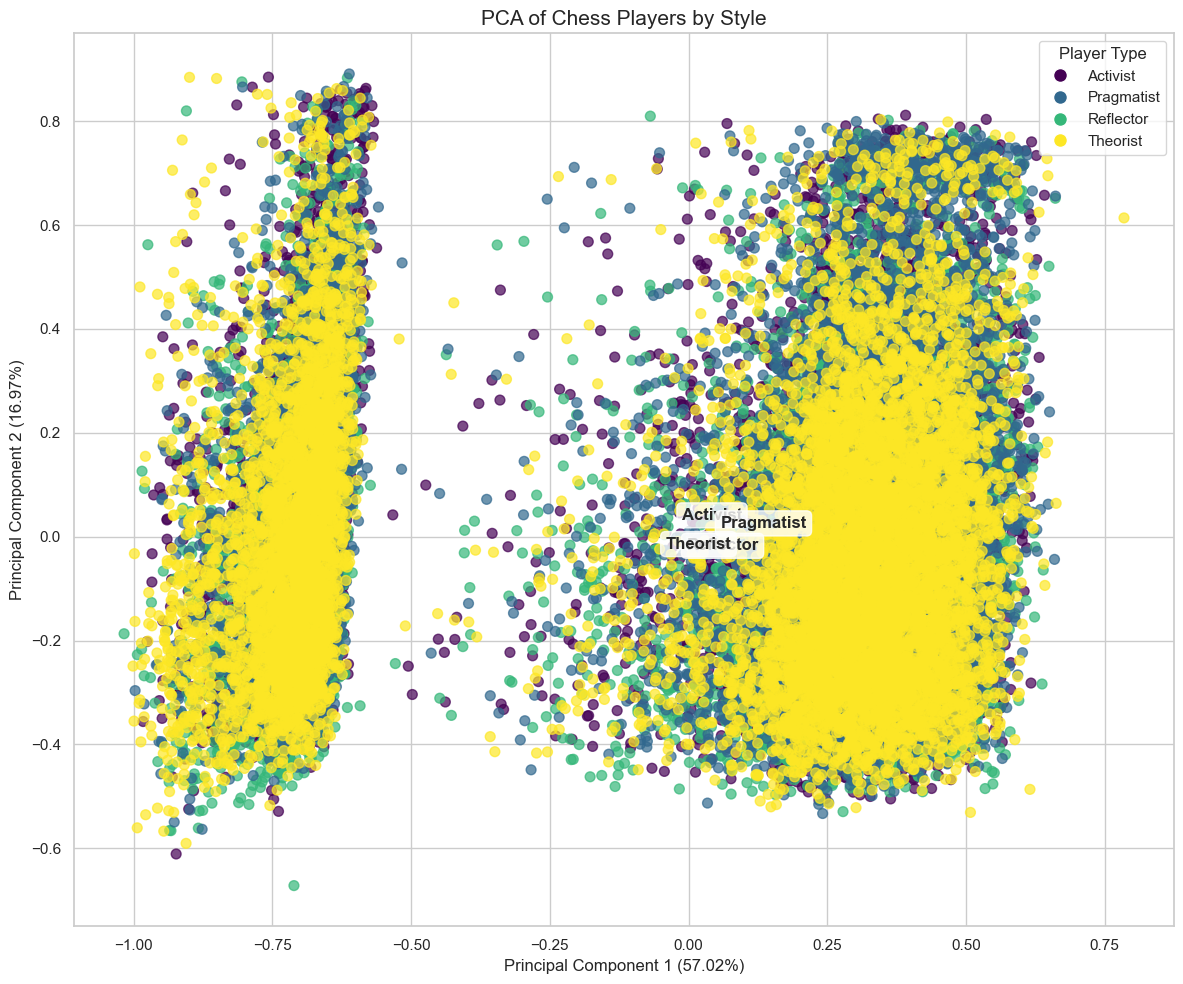

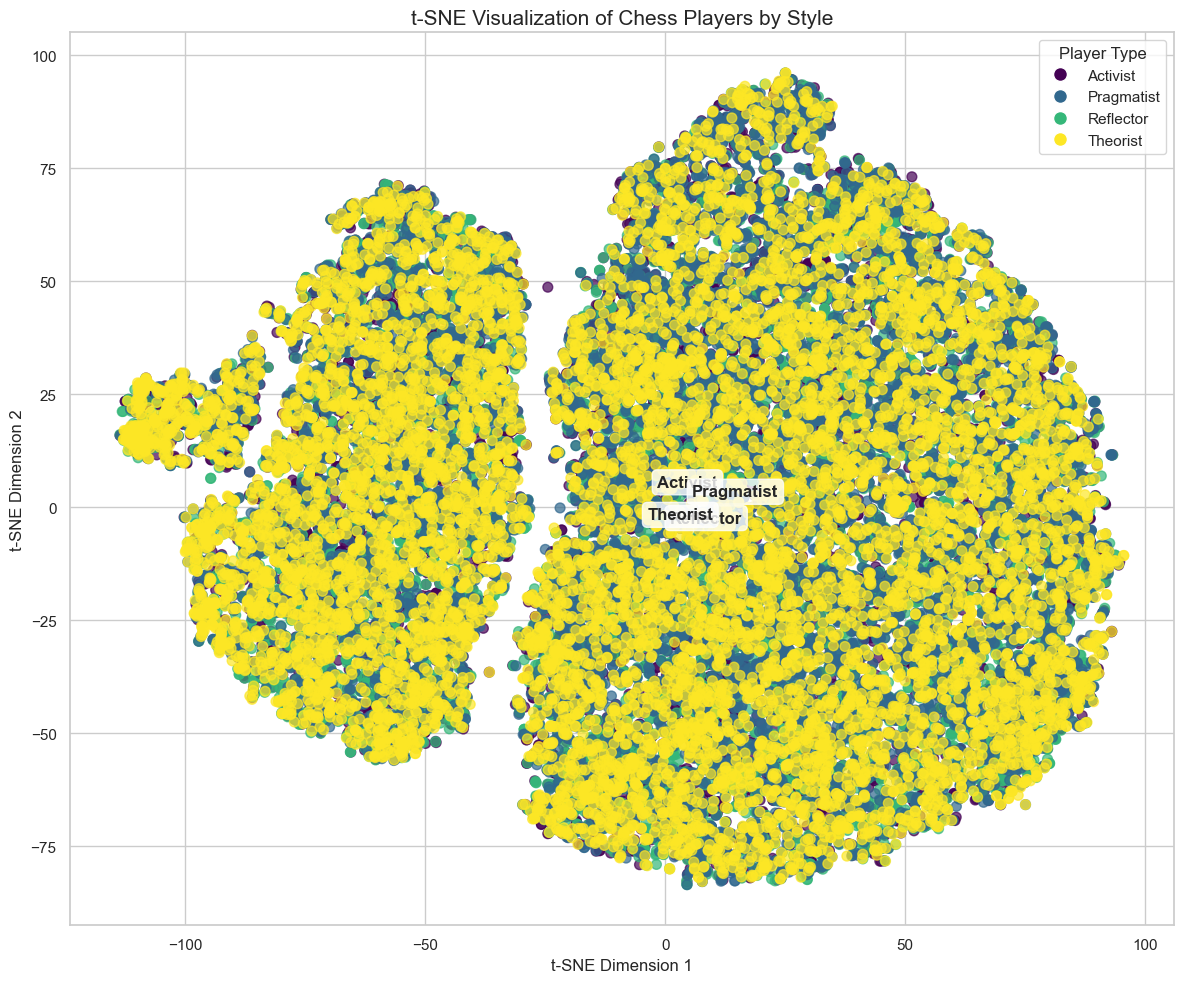

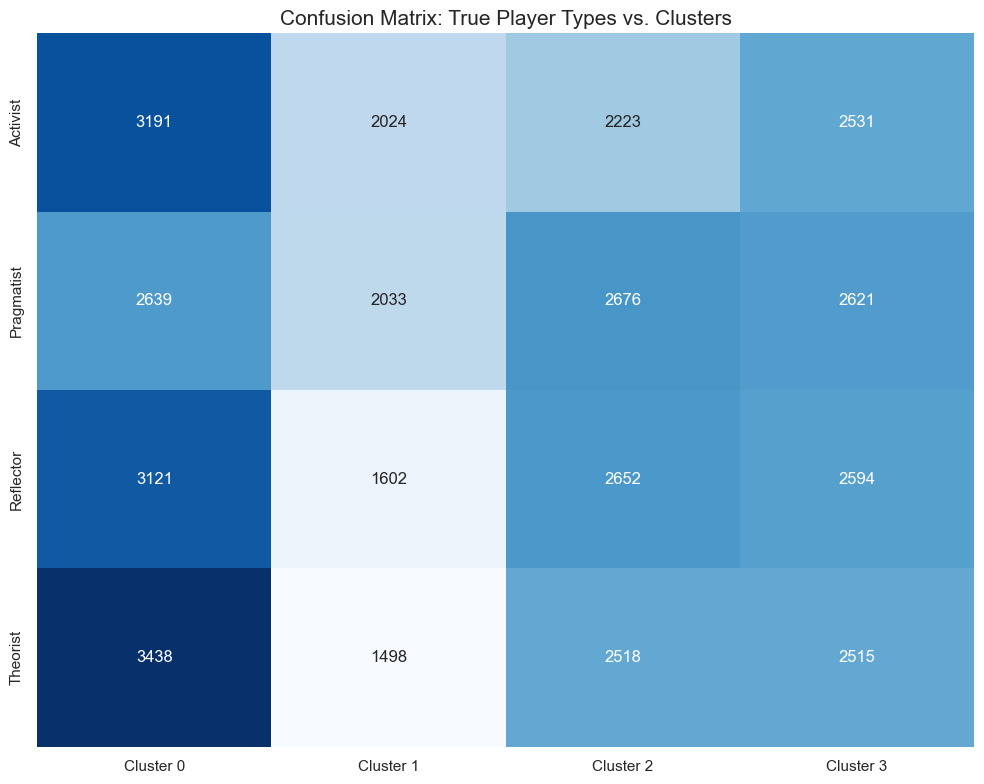

Analysis complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Set the display options
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ------------------------------------------------------
# 1. LOAD AND PREPARE DATA
# ------------------------------------------------------
print("Loading and preparing data...")

# Load the player-centric data
try:
    players_df = pd.read_csv('player_centric_data.csv')
    print(f"Original dataset shape: {players_df.shape}")
    print("\nPlayer types in dataset:")
    print(players_df['player_type'].value_counts(dropna=False))
    
    # Get only rows with known player types
    typed_df = players_df[players_df['player_type'].notna()].copy()
    
    # Sample equal numbers from each player type (not player name)
    min_count = typed_df['player_type'].value_counts().min()
    print(f"\nBalancing dataset by sampling {min_count} games from each player type")
    
    balanced_df = pd.DataFrame()
    for player_type in typed_df['player_type'].unique():
        player_type_data = typed_df[typed_df['player_type'] == player_type]
        # Sample the minimum count (with replacement if necessary)
        if len(player_type_data) < min_count:
            sampled = player_type_data.sample(min_count, replace=True)
        else:
            sampled = player_type_data.sample(min_count, replace=False)
        balanced_df = pd.concat([balanced_df, sampled])
    
    print(f"Balanced dataset shape: {balanced_df.shape}")
    print(balanced_df['player_type'].value_counts())
except Exception as e:
    print(f"Error loading data: {e}")
    # If there's an error with the real data, the synthetic data generation will run

# ------------------------------------------------------
# 2. FEATURE ENGINEERING
# ------------------------------------------------------
print("\nPerforming feature engineering...")

# Define columns to exclude from feature set (metadata)
meta_cols = ['player_name', 'player_color', 'opponent_name', 
            'player_type', 'game_id', 'result', 'date', 
            'eco', 'opening_name', 'player_elo']

# Get existing feature columns
base_feature_cols = [col for col in balanced_df.columns if col not in meta_cols]
print(f"Base features: {len(base_feature_cols)}")

# Create new composite features
print("Creating composite features...")

# Only create new features if they don't already exist
if 'tactical_score' not in balanced_df.columns:
    # Create tactical score (combination of tactical metrics)
    if all(x in balanced_df.columns for x in ['brilliant_count', 'sacrifice_count', 'blunder_count', 'top_move_alignment']):
        balanced_df['tactical_score'] = (
            balanced_df['brilliant_count'] * 2 + 
            balanced_df.get('sacrifice_count', 0) * 1.5 -
            balanced_df['blunder_count'] * 1 + 
            (1 - balanced_df['top_move_alignment']) * 0.5
        )

if 'positional_score' not in balanced_df.columns:
    # Create positional score
    if 'center_control_avg' in balanced_df.columns and 'piece_mobility_avg' in balanced_df.columns:
        balanced_df['positional_score'] = (
            balanced_df.get('center_control_avg', 0) * 2 + 
            balanced_df.get('piece_mobility_avg', 0) / 100
        )

if 'development_efficiency' not in balanced_df.columns:
    # Create development efficiency if the needed columns exist
    if 'minor_piece_development' in balanced_df.columns and 'queen_development' in balanced_df.columns:
        balanced_df['development_efficiency'] = (
            1 - (balanced_df.get('minor_piece_development', 0) + balanced_df.get('queen_development', 0)) / 2
        )

if 'dynamic_play_index' not in balanced_df.columns:
    # Create dynamic play index if columns exist
    if 'sharpness' in balanced_df.columns:
        balanced_df['dynamic_play_index'] = (
            balanced_df.get('capture_frequency', 0) * 2 + 
            balanced_df.get('check_frequency', 0) * 3 + 
            balanced_df['sharpness'] / 3
        )

if 'theoretical_adherence' not in balanced_df.columns:
    # Create theoretical adherence if needed columns exist
    if 'opening_novelty_score' in balanced_df.columns and 'top_move_alignment' in balanced_df.columns:
        balanced_df['theoretical_adherence'] = (
            balanced_df['opening_novelty_score'] * 0.7 + 
            balanced_df['top_move_alignment'] * 0.3
        )

# Get updated feature list (including new composite features)
feature_cols = [col for col in balanced_df.columns if col not in meta_cols]
print(f"Total features after engineering: {len(feature_cols)}")

# Change categorical features to numerical
categorical_features = ['player_color', 'result']
for feature in categorical_features:
    if feature in balanced_df.columns:
        balanced_df[feature] = balanced_df[feature].astype('category')
        balanced_df[feature] = balanced_df[feature].cat.codes

# ------------------------------------------------------
# 3. DATA PREPARATION
# ------------------------------------------------------
print("\nPreparing data for analysis...")

# Handle missing values based on player means
for col in feature_cols:
    if balanced_df[col].isnull().sum() > 0:
        print(f"Handling missing values in {col}")
        # Group by player_name and calculate mean for this feature
        player_means = balanced_df.groupby('player_name')[col].transform('mean')
        # Fill NaN with player mean, or dataset median if player mean is also NaN
        balanced_df[col] = balanced_df[col].fillna(player_means).fillna(balanced_df[col].median())

# Create X (features) and y (true player types)
X = balanced_df[feature_cols]
y = balanced_df['player_type']

# Encode player types
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
player_type_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Player type mapping:", player_type_mapping)

# Scale features to 0-1 range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------
# 4. FEATURE SELECTION
# ------------------------------------------------------
print("\nPerforming feature selection...")

# Use SelectKBest to find most discriminative features
selector = SelectKBest(f_classif, k=min(15, len(feature_cols)))
selector.fit(X_scaled, y_encoded)

# Get selected features and their scores
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector.scores_
})
top_features = feature_scores.sort_values('Score', ascending=False).head(min(15, len(feature_cols)))['Feature'].tolist()

print("\nTop discriminative features:")
for i, (feature, score) in enumerate(zip(top_features, 
                                        feature_scores.sort_values('Score', ascending=False).head(min(15, len(feature_cols)))['Score'].tolist())):
    print(f"{i+1}. {feature}: {score:.2f}")

# Use these features for further analysis
X_selected = X_scaled[:, selector.get_support()]

# ------------------------------------------------------
# 5. DIMENSIONALITY REDUCTION FOR VISUALIZATION
# ------------------------------------------------------
print("\nReducing dimensionality for visualization...")

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_selected)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

# Try t-SNE for better visualization
print("Applying t-SNE...")
perplexity_value = min(30, len(X_selected) // 5)
if perplexity_value < 5:  # t-SNE needs a reasonable perplexity value
    perplexity_value = 5
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
tsne_result = tsne.fit_transform(X_selected)

# ------------------------------------------------------
# 6. CLUSTERING ANALYSIS
# ------------------------------------------------------
print("\nPerforming clustering analysis...")

# Determine optimal number of clusters based on expected player types
n_player_types = len(np.unique(y_encoded))
print(f"Number of unique player types in data: {n_player_types}")

# For small datasets, we limit clusters to prevent overfitting
max_clusters = min(10, len(X_selected) // 5)
optimal_k = min(n_player_types, max_clusters)
if optimal_k < 2:
    optimal_k = 2  # At least 2 clusters

print(f"Using k={optimal_k} for K-means")

# Perform K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_selected)

# Calculate clustering performance
ari_score = adjusted_rand_score(y_encoded, cluster_labels)
print(f"Adjusted Rand Index (measure of cluster quality): {ari_score:.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(y_encoded, cluster_labels)

# Fix the shape issue by ensuring the index and columns match the shape of conf_matrix
if conf_matrix.shape[0] == len(label_encoder.classes_) and conf_matrix.shape[1] == optimal_k:
    conf_df = pd.DataFrame(conf_matrix, 
                         index=label_encoder.classes_,
                         columns=[f'Cluster {i}' for i in range(optimal_k)])
else:
    conf_df = pd.DataFrame(conf_matrix, 
                         index=[f'Type {i}' for i in range(conf_matrix.shape[0])],
                         columns=[f'Cluster {i}' for i in range(conf_matrix.shape[1])])

print("\nConfusion Matrix (True Player Types vs. Clusters):")
print(conf_df)

# Map clusters to player types
cluster_to_player = {}
for cluster in range(optimal_k):
    if cluster < conf_matrix.shape[1]:
        cluster_counts = conf_matrix[:, cluster]
        dominant_type = label_encoder.classes_[np.argmax(cluster_counts)]
        cluster_to_player[cluster] = dominant_type

print("\nCluster to Player Type Mapping:")
for cluster, player_type in cluster_to_player.items():
    print(f"Cluster {cluster} -> {player_type}")

# ------------------------------------------------------
# 7. SUPERVISED CLASSIFICATION
# ------------------------------------------------------
print("\nPerforming supervised classification...")

# Split data for training and testing - only if we have enough samples
if len(X_selected) >= 10:  # Need reasonable amount of data
    # Split data for training and testing
    test_size = min(0.3, 1/n_player_types)  # Adjust test size for small datasets
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )

    # Train a Random Forest classifier
    n_estimators = min(100, X_train.shape[0])  # Limit trees for small datasets
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate with cross-validation if we have enough samples
    if len(X_selected) >= 10:
        cv = min(5, n_player_types)  # Adjust CV for small datasets
        cv_scores = cross_val_score(rf, X_selected, y_encoded, cv=cv)
        print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # Predict on test set
    y_pred = rf.predict(X_test)
    print("\nClassification Report:")

    # Fix for classification_report to ensure labels parameter is set correctly
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))
    target_names = [label_encoder.classes_[i] for i in unique_labels]
    print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

    # Feature importance from Random Forest
    feature_importance = pd.DataFrame({
        'Feature': [feature_cols[i] for i in selector.get_support(indices=True)],
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature importance from Random Forest:")
    for i, row in feature_importance.head(min(10, len(feature_importance))).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
else:
    print("Not enough data for supervised classification.")

# ------------------------------------------------------
# 8. STYLE DIMENSION ANALYSIS
# ------------------------------------------------------
print("\nAnalyzing style dimensions...")

# Define style dimensions based on available features
style_dimensions = {}

# Check which dimensions we can analyze based on available features
if any(f in balanced_df.columns for f in ['tactical_score', 'brilliant_count', 'sacrifice_count', 'blunder_count']):
    style_dimensions['tactical_tendency'] = [f for f in ['tactical_score', 'brilliant_count', 'sacrifice_count', 'blunder_count'] 
                                            if f in balanced_df.columns]

if any(f in balanced_df.columns for f in ['positional_score', 'center_control_avg', 'piece_mobility_avg']):
    style_dimensions['positional_sense'] = [f for f in ['positional_score', 'center_control_avg', 'piece_mobility_avg'] 
                                           if f in balanced_df.columns]

if any(f in balanced_df.columns for f in ['theoretical_adherence', 'opening_novelty_score', 'top_move_alignment']):
    style_dimensions['theoretical_knowledge'] = [f for f in ['theoretical_adherence', 'opening_novelty_score', 'top_move_alignment'] 
                                              if f in balanced_df.columns]

if any(f in balanced_df.columns for f in ['dynamic_play_index', 'capture_frequency', 'check_frequency', 'sharpness']):
    style_dimensions['dynamic_play'] = [f for f in ['dynamic_play_index', 'capture_frequency', 'check_frequency', 'sharpness'] 
                                      if f in balanced_df.columns]

if any(f in balanced_df.columns for f in ['development_efficiency', 'minor_piece_development', 'queen_development']):
    style_dimensions['developmental_approach'] = [f for f in ['development_efficiency', 'minor_piece_development', 'queen_development'] 
                                               if f in balanced_df.columns]

if 'opening_length' in balanced_df.columns and 'middlegame_length' in balanced_df.columns and 'endgame_length' in balanced_df.columns:
    style_dimensions['phase_focus'] = ['opening_length', 'middlegame_length', 'endgame_length']

# Calculate dimension scores for each player
dimension_scores = pd.DataFrame()

# For each dimension, calculate scores for each player
for dimension, features in style_dimensions.items():
    # Filter to only keep features that exist in the dataset
    valid_features = [f for f in features if f in balanced_df.columns]
    
    if not valid_features:
        print(f"No valid features for {dimension}, skipping")
        continue
        
    # Normalize features within this dimension
    dimension_data = balanced_df[valid_features].copy()
    dimension_scaler = MinMaxScaler()
    dimension_normalized = dimension_scaler.fit_transform(dimension_data)
    
    # Calculate average score for this dimension
    dimension_scores[dimension] = np.mean(dimension_normalized, axis=1)

# Add player information
dimension_scores['player_name'] = balanced_df['player_name']
dimension_scores['player_type'] = balanced_df['player_type']

# Calculate average scores by player type
try:
    style_profile = dimension_scores.groupby('player_type').mean(numeric_only=True)
    style_profile = style_profile.drop(columns=['player_name'], errors='ignore')
except (TypeError, KeyError) as e:
    print(f"Error calculating style profiles: {e}")
    style_profile = pd.DataFrame()

if not style_profile.empty:
    print("\nStyle Dimension Profiles by Player Type:")
    print(style_profile.round(3))

# ------------------------------------------------------
# 8.5 PLAYER-LEVEL CLUSTERING
# ------------------------------------------------------
print("\nPerforming player-level clustering...")

# Create player-level aggregated features
player_features = pd.DataFrame()

# Group by player_name and aggregate
for col in feature_cols:
    # Skip columns that aren't numeric
    if not np.issubdtype(balanced_df[col].dtype, np.number):
        continue
        
    # Calculate various statistics per player
    player_features[f'{col}_mean'] = balanced_df.groupby('player_name')[col].mean()
    # Add standard deviation to capture consistency/variability
    player_features[f'{col}_std'] = balanced_df.groupby('player_name')[col].std().fillna(0)

# Get the player types
player_types = balanced_df.groupby('player_name')['player_type'].first()
player_features['player_type'] = player_types

# Remove players with unknown type for supervised analysis
player_features_typed = player_features.dropna(subset=['player_type']).copy()

if len(player_features_typed) >= 4:  # Need enough players for meaningful clustering
    # Prepare data for clustering
    X_player = player_features_typed.drop(columns=['player_type'])
    y_player = player_features_typed['player_type']
    
    # Encode player types
    player_label_encoder = LabelEncoder()
    y_player_encoded = player_label_encoder.fit_transform(y_player)
    
    # Scale features
    player_scaler = MinMaxScaler()
    X_player_scaled = player_scaler.fit_transform(X_player)
    
    # Use PCA for visualization
    player_pca = PCA(n_components=2)
    player_pca_result = player_pca.fit_transform(X_player_scaled)
    
    # Cluster players
    n_player_clusters = min(len(np.unique(y_player)), len(player_features_typed) - 1)
    if n_player_clusters < 2:
        n_player_clusters = 2
    
    player_kmeans = KMeans(n_clusters=n_player_clusters, random_state=42, n_init=10)
    player_cluster_labels = player_kmeans.fit_predict(X_player_scaled)
    
    # Calculate clustering performance
    player_ari = adjusted_rand_score(y_player_encoded, player_cluster_labels)
    print(f"Player-level clustering ARI: {player_ari:.4f}")
    
    # Create confusion matrix
    player_conf_matrix = confusion_matrix(y_player_encoded, player_cluster_labels)
    player_conf_df = pd.DataFrame(player_conf_matrix, 
                             index=player_label_encoder.classes_,
                             columns=[f'Cluster {i}' for i in range(n_player_clusters)])
    
    print("\nPlayer-Level Confusion Matrix (True Player Types vs. Clusters):")
    print(player_conf_df)
    
    # Visualize player clusters
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        player_pca_result[:, 0], player_pca_result[:, 1], 
        c=y_player_encoded, cmap='viridis', 
        s=100, alpha=0.7
    )
    
    # Add player names as annotations
    for i, player in enumerate(player_features_typed.index):
        plt.annotate(player.split(',')[0], 
                    (player_pca_result[i, 0], player_pca_result[i, 1]),
                    fontsize=9, 
                    alpha=0.7)
    
    plt.title('PCA of Chess Players (Aggregated Style)', fontsize=15)
    plt.xlabel(f'Principal Component 1 ({player_pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
    plt.ylabel(f'Principal Component 2 ({player_pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
    
    # Add a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=scatter.cmap(scatter.norm(i)),
                                label=player_label_encoder.classes_[i], markersize=10) 
                      for i in range(len(player_label_encoder.classes_))]
    plt.legend(handles=legend_elements, title='Player Type', loc='best')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough players with known types for player-level clustering.")

# ------------------------------------------------------
# 9. VISUALIZATION
# ------------------------------------------------------
print("\nCreating visualizations...")

# 1. Visualize PCA results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1], 
    c=y_encoded, cmap='viridis', 
    s=50, alpha=0.7
)
plt.title('PCA of Chess Players by Style', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)),
                             label=label_encoder.classes_[i], markersize=10) 
                  for i in range(len(label_encoder.classes_))]
plt.legend(handles=legend_elements, title='Player Type', loc='best')

# Add centroids for each player type
for i, player_type in enumerate(label_encoder.classes_):
    mask = y_encoded == i
    centroid = np.mean(pca_result[mask], axis=0)
    plt.annotate(player_type, xy=centroid, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 2. Visualize t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1], 
    c=y_encoded, cmap='viridis', 
    s=50, alpha=0.7
)
plt.title('t-SNE Visualization of Chess Players by Style', fontsize=15)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)),
                             label=label_encoder.classes_[i], markersize=10) 
                  for i in range(len(label_encoder.classes_))]
plt.legend(handles=legend_elements, title='Player Type', loc='best')

# Add centroids for each player type
for i, player_type in enumerate(label_encoder.classes_):
    mask = y_encoded == i
    centroid = np.mean(tsne_result[mask], axis=0)
    plt.annotate(player_type, xy=centroid, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Visualize the style profiles with radar chart if we have enough dimensions
if not style_profile.empty and style_profile.shape[1] >= 3:
    plt.figure(figsize=(12, 10))
    # Radar chart preparation
    dimensions = list(style_profile.columns)
    N = len(dimensions)

    # Create angles for each dimension
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create radar plot for each player type
    ax = plt.subplot(111, polar=True)

    # Add player type lines
    colors = plt.cm.viridis(np.linspace(0, 1, len(style_profile)))
    for i, (player_type, values) in enumerate(style_profile.iterrows()):
        values = values.values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=player_type, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dimensions)
    ax.set_yticklabels([])

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Player Type Style Profiles', size=15)

    plt.tight_layout()
    plt.savefig('style_profile_radar.png')
    plt.close()

# 4. Feature importance visualization - if we ran supervised classification
if 'feature_importance' in locals():
    plt.figure(figsize=(12, 8))
    top_n = min(10, len(feature_importance))
    sns.barplot(data=feature_importance.head(top_n), x='Importance', y='Feature')
    plt.title('Top Features for Differentiating Player Styles', fontsize=15)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

# 5. Confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix: True Player Types vs. Clusters', fontsize=15)
plt.tight_layout()
plt.show()

print("Analysis complete.")

Loading data...
Dataset shape: (99422, 50)

Player types distribution:
player_type
NaN           45545
Theorist      17323
Activist      16266
Pragmatist    10319
Reflector      9969
Name: count, dtype: int64

Dataset with known player types: (53877, 50)

Number of features: 40

1. BASIC FEATURE STATISTICS

Features with most missing values:
                         missing  missing_pct
minor_piece_development        0          0.0
queen_development              0          0.0
eval_volatility                0          0.0
sacrifice_count                0          0.0
prophylactic_frequency         0          0.0
brilliant_count                0          0.0
great_count                    0          0.0
good_moves                     0          0.0
inaccuracy_count               0          0.0
mistake_count                  0          0.0

2. FEATURE DISTRIBUTIONS

Features with highest skewness (potentially need transformation):
                         skewness
blunder_count          

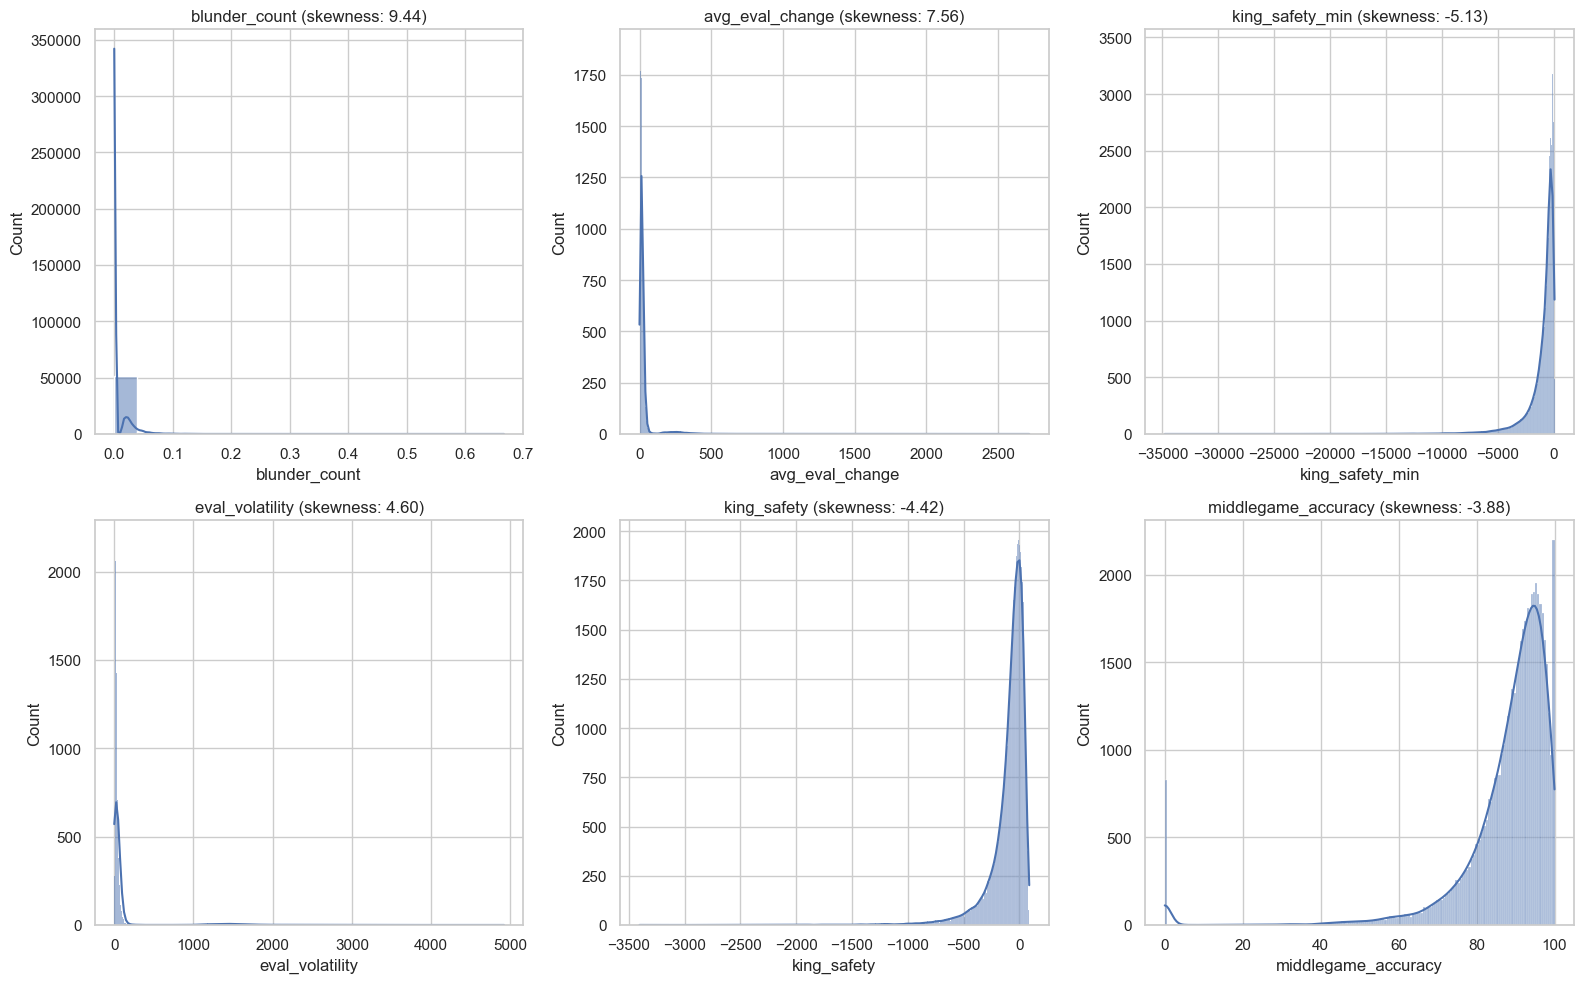


3. FEATURE CORRELATIONS

Highly correlated feature pairs (|r| > 0.7):
avg_eval_change and eval_volatility: 0.951
king_safety and king_safety_min: 0.843
material_changes and capture_frequency: 0.827
material_volatility and piece_exchange_rate: 0.813
material_changes and material_volatility: 0.809
total_moves and opening_length: -0.773
good_moves and inaccuracy_count: -0.771
sacrifice_count and brilliant_count: 0.770
piece_exchange_rate and capture_frequency: 0.768
total_moves and endgame_length: 0.741


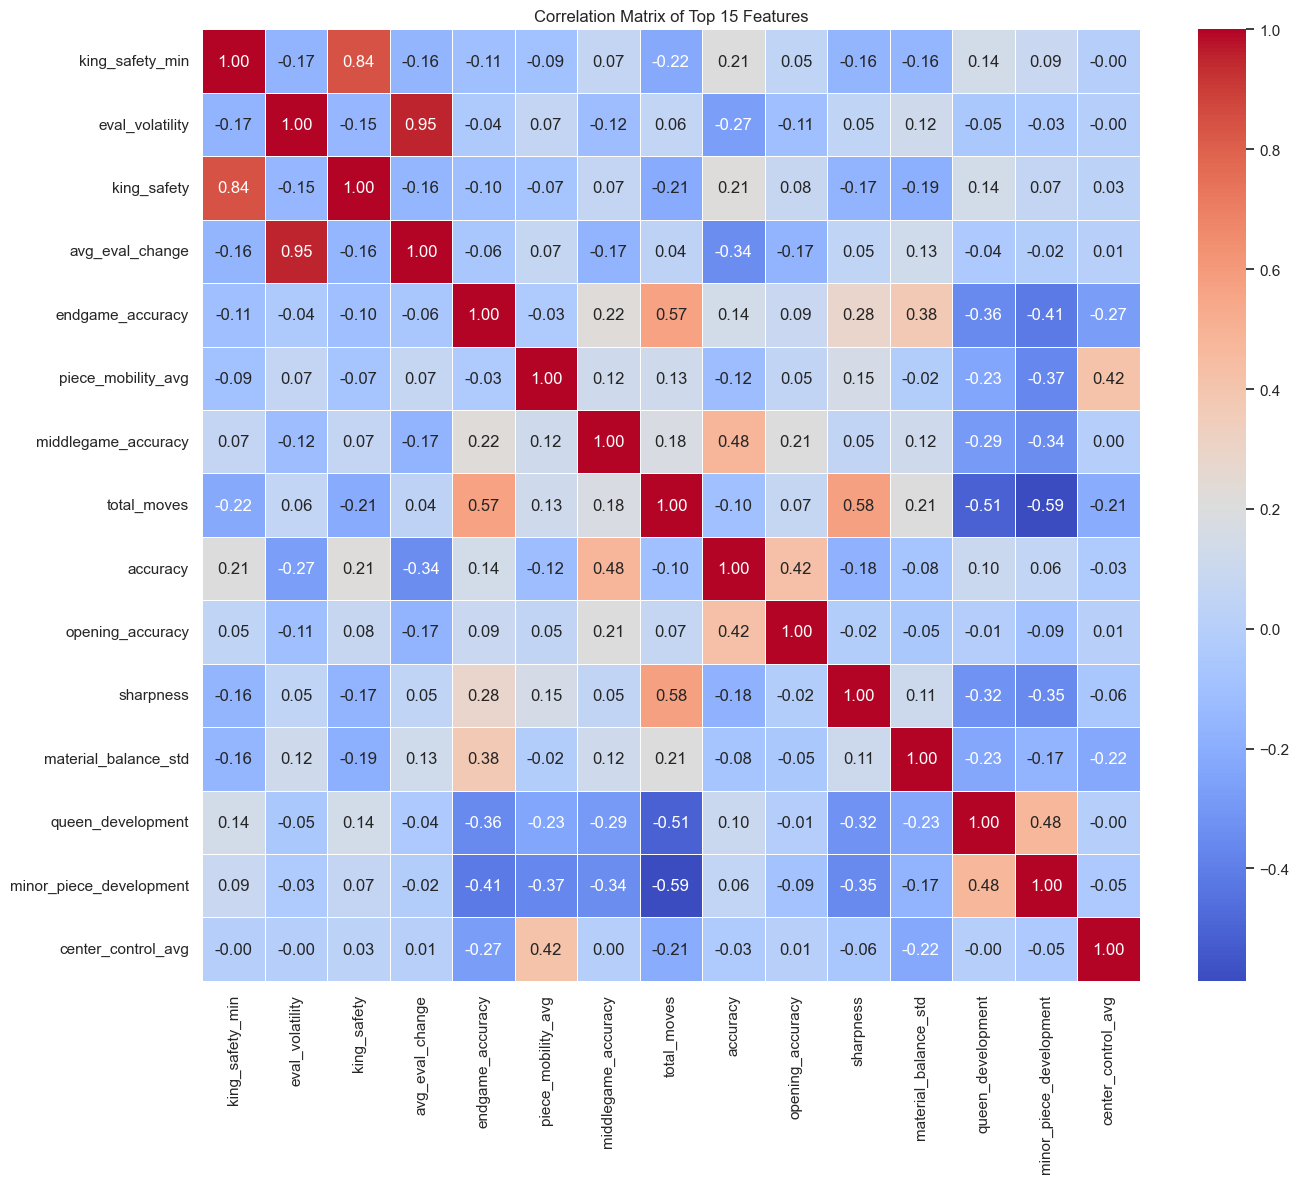


4. FEATURE DISCRIMINATIVE POWER

Top 15 features by ANOVA F-score:
                    Feature     F-Score        P-Value
12          space_advantage  170.161574  8.438930e-110
39    opening_novelty_score  139.960696   2.455231e-90
31       top_move_alignment  118.709486   1.258065e-76
35           opening_length  103.099148   1.500606e-66
27               good_moves  102.212592   5.606231e-66
38     material_balance_std   89.616455   7.629847e-58
3          material_changes   86.587814   6.894353e-56
34              total_moves   81.008818   2.765170e-52
18         opening_accuracy   80.289994   8.053585e-52
32    top2_3_move_alignment   74.178765   7.129826e-48
0   minor_piece_development   71.029453   7.711058e-46
20         endgame_accuracy   68.392635   3.891341e-44
24   prophylactic_frequency   64.303918   1.700791e-41
17                 accuracy   62.318362   3.257354e-40
37           endgame_length   61.775533   7.301215e-40


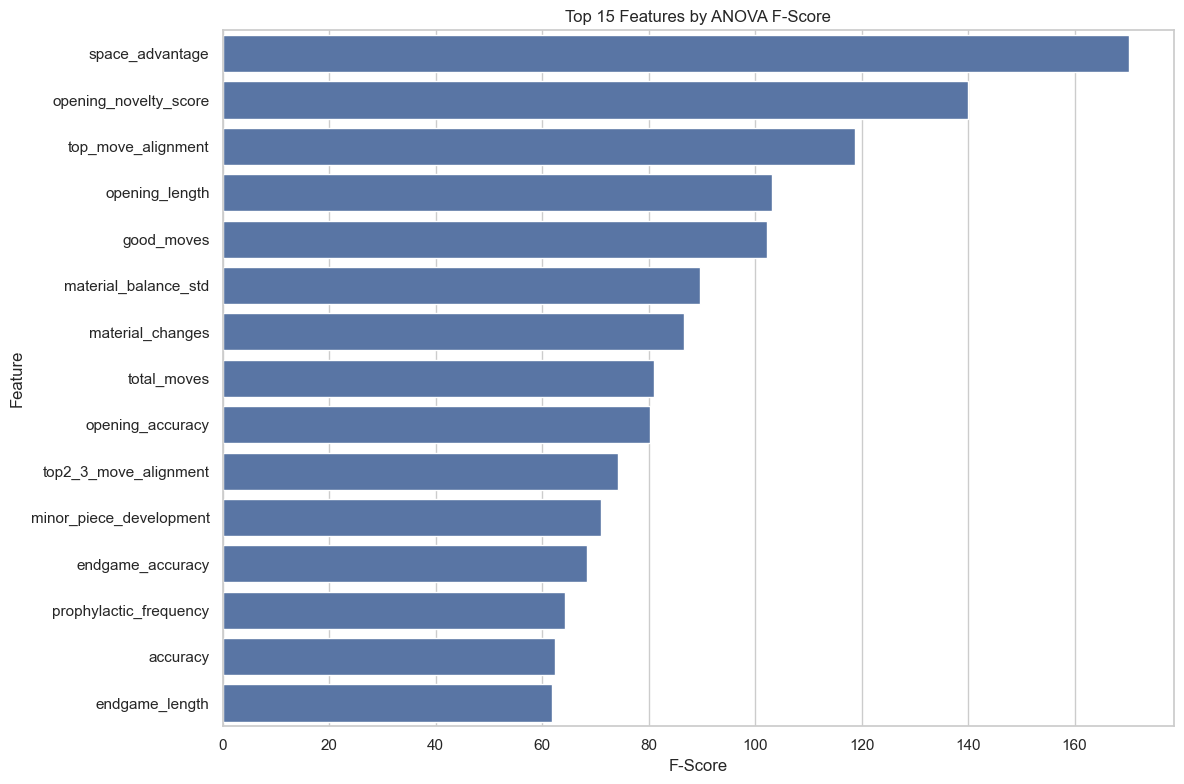


5. MUTUAL INFORMATION ANALYSIS

Top 15 features by Mutual Information:
                    Feature  MI-Score
38     material_balance_std  0.023928
10             pawn_control  0.017332
13              king_safety  0.015711
8        piece_mobility_avg  0.013841
12          space_advantage  0.011859
2               castle_move  0.011329
14          king_safety_min  0.009342
11       center_control_avg  0.008774
1         queen_development  0.007938
0   minor_piece_development  0.007746
33                sharpness  0.007657
31       top_move_alignment  0.007518
15     vulnerability_spikes  0.007266
3          material_changes  0.006718
20         endgame_accuracy  0.006339


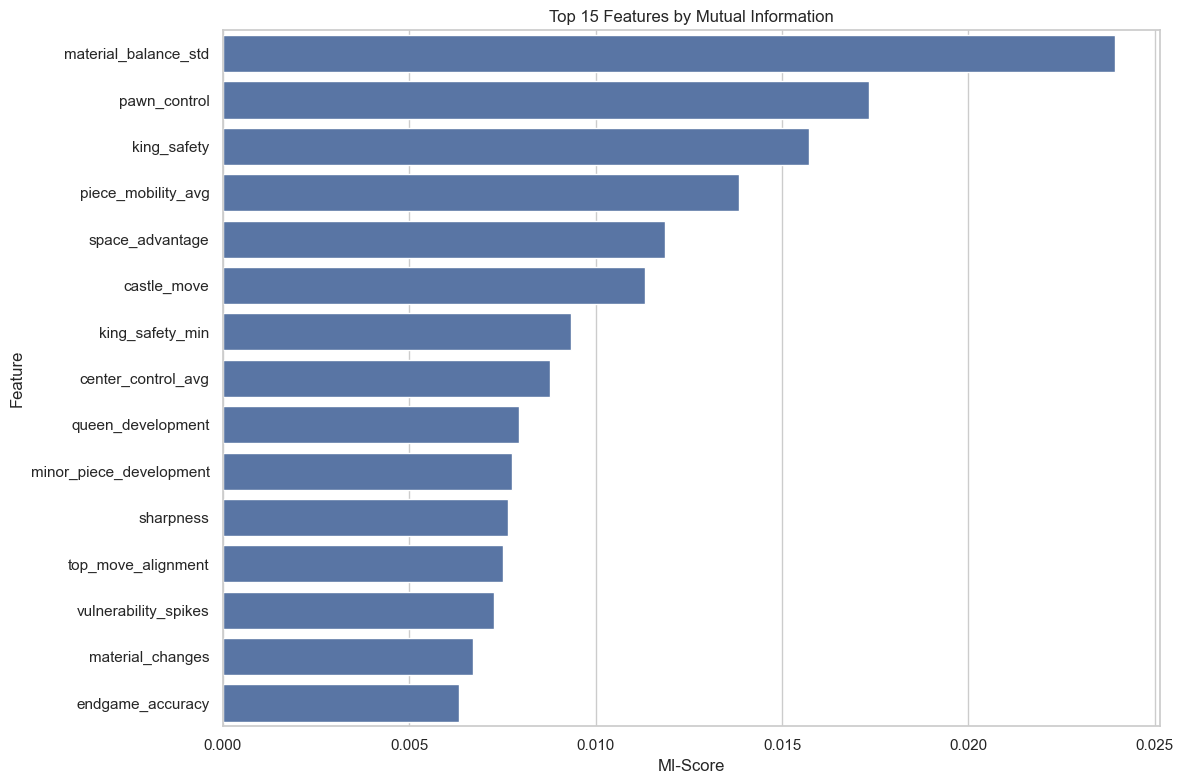


6. COMPARING FEATURE RANKINGS

Features with biggest ranking differences (ANOVA vs Mutual Information):
                  Feature  F-Score Rank  MI Rank  Rank Difference
10           pawn_control            37        2               35
14        king_safety_min            36        7               29
17               accuracy            14       40              -26
8      piece_mobility_avg            30        4               26
27             good_moves             5       31              -26
13            king_safety            29        3               26
39  opening_novelty_score             2       25              -23
15   vulnerability_spikes            35       13               22
33              sharpness            32       11               21
28       inaccuracy_count            19       38              -19

7. RANDOM FOREST FEATURE IMPORTANCE

Top 15 features by Random Forest importance:
                    Feature  Importance
12          space_advantage    0.032761
10    

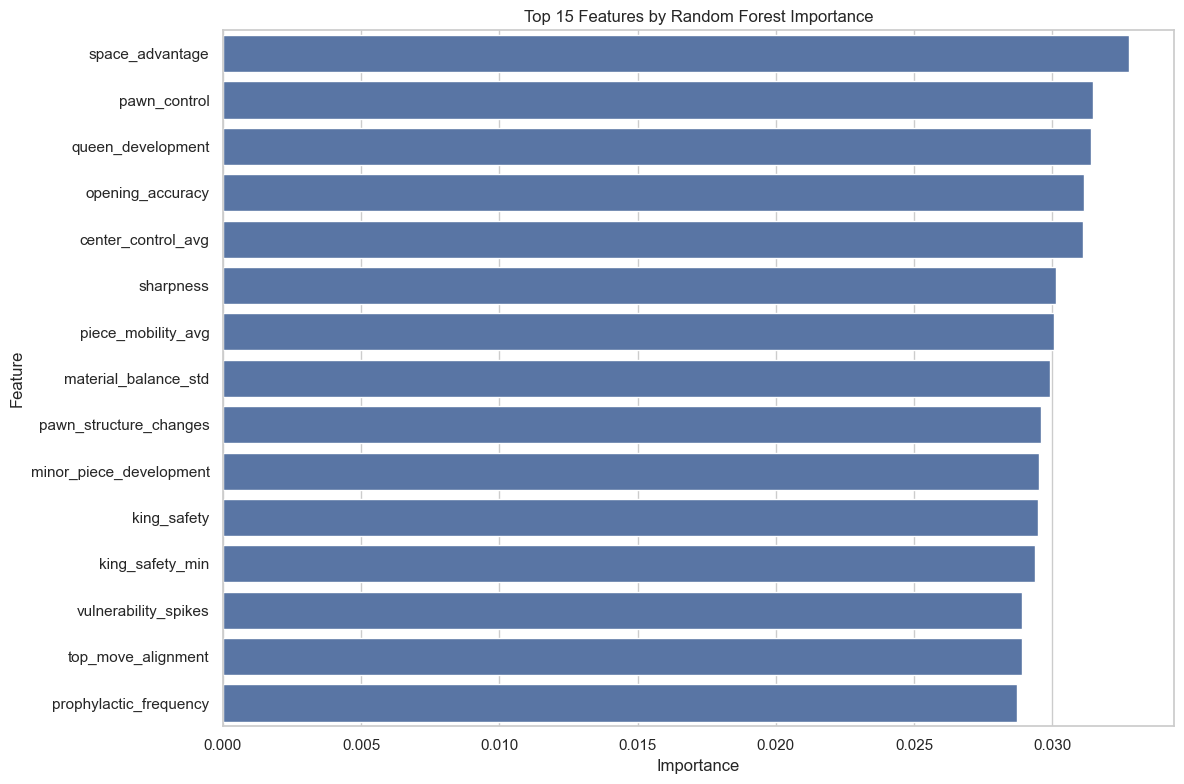


8. COMPARING ALL FEATURE RANKINGS

Top 15 features by average rank across all methods:
                    Feature  F-Score Rank  MI Rank  RF Rank   Avg Rank
12          space_advantage             1        5        1   2.333333
38     material_balance_std             6        1        8   5.000000
1         queen_development            17        9        3   9.666667
31       top_move_alignment             3       12       14   9.666667
0   minor_piece_development            11       10       10  10.333333
11       center_control_avg            21        8        5  11.333333
18         opening_accuracy             9       22        4  11.666667
8        piece_mobility_avg            30        4        7  13.666667
10             pawn_control            37        2        2  13.666667
13              king_safety            29        3       11  14.333333
3          material_changes             7       14       25  15.333333
35           opening_length             4       17       26 

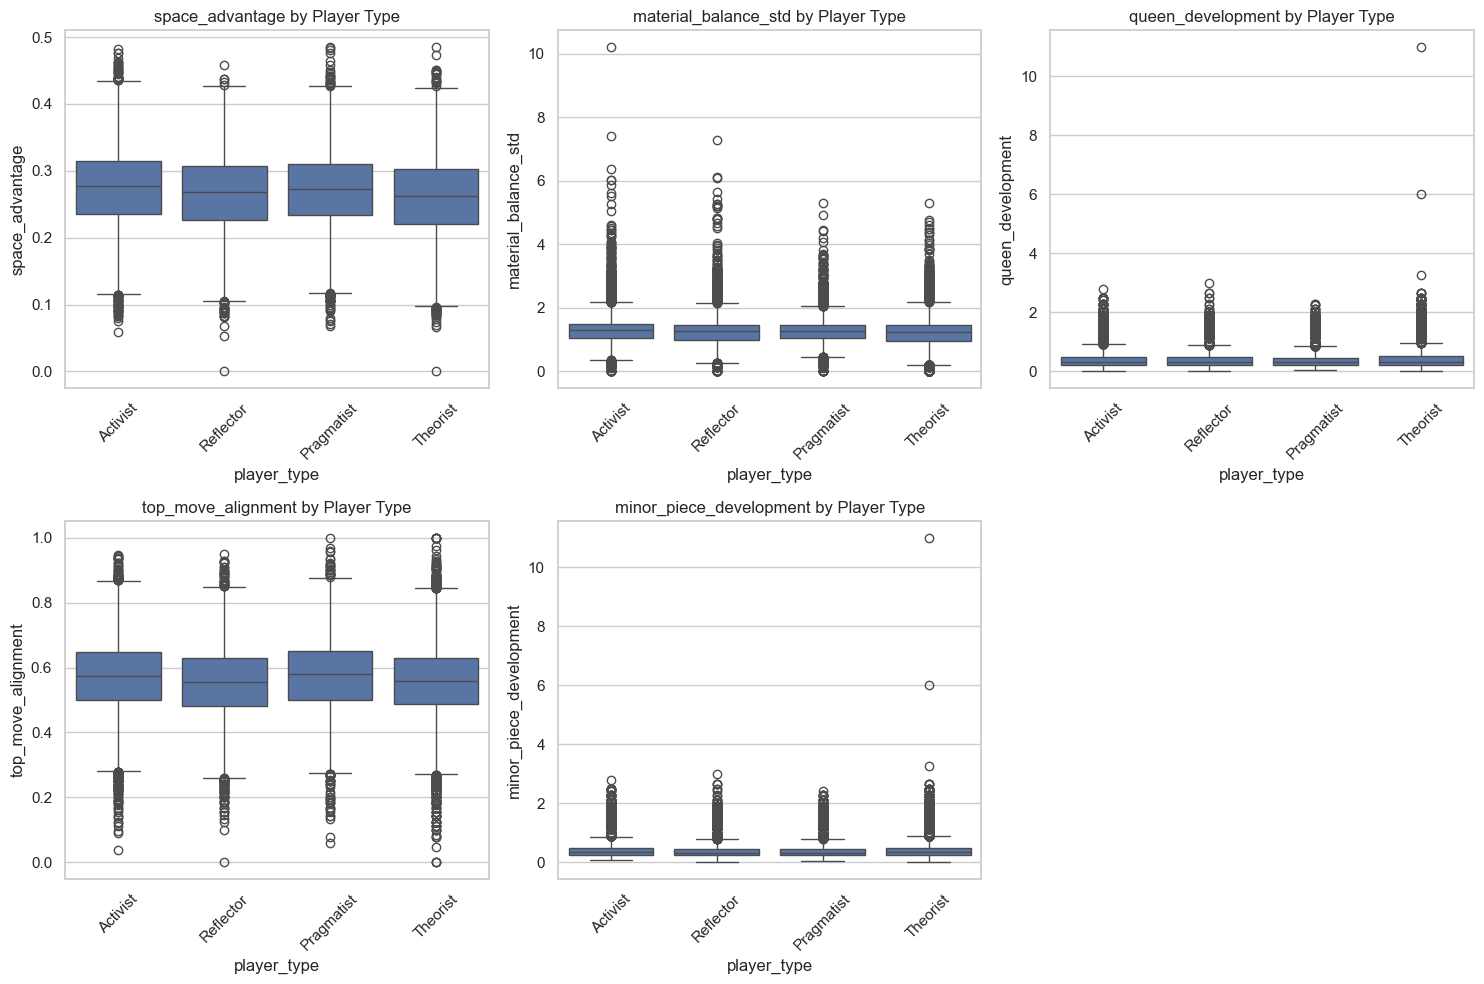

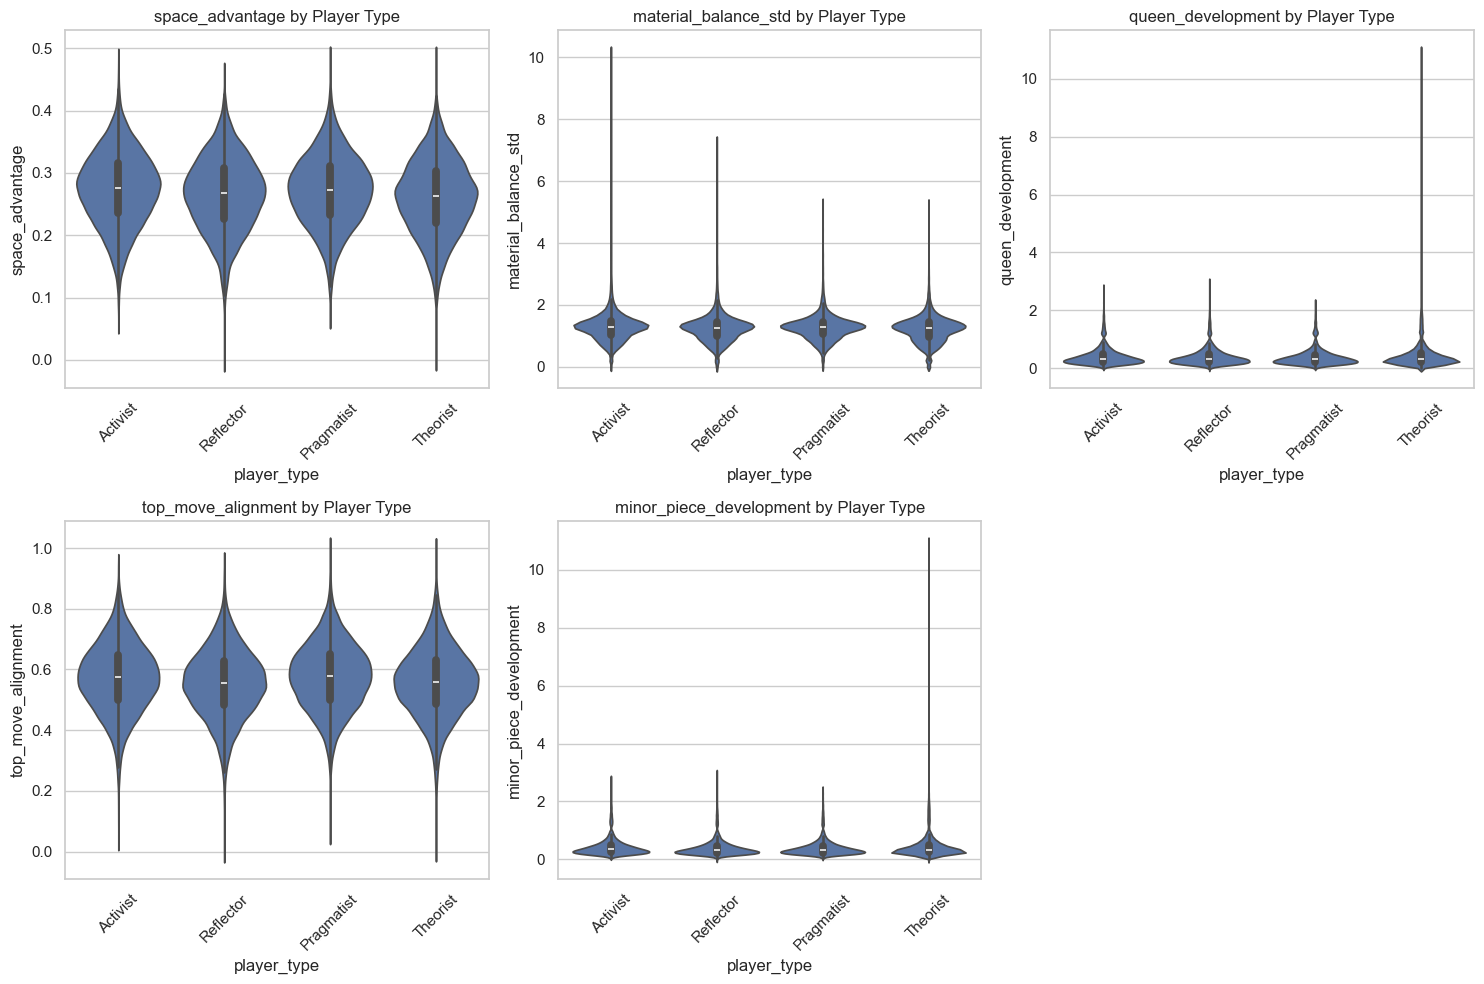


10. FEATURE MEANS BY PLAYER TYPE

Features with largest percentage differences between player types:
                         Max % Difference
blunder_count                   23.611762
great_count                     20.351029
sacrifice_count                 19.904462
brilliant_count                 18.622784
mistake_count                   18.217888
king_safety                     18.105490
eval_volatility                 17.121255
avg_eval_change                 16.403071
endgame_length                  14.571295
king_safety_min                 13.543874
inaccuracy_count                12.806191
endgame_accuracy                12.195447
check_frequency                 12.023403
queen_development               11.691419
minor_piece_development         11.061242


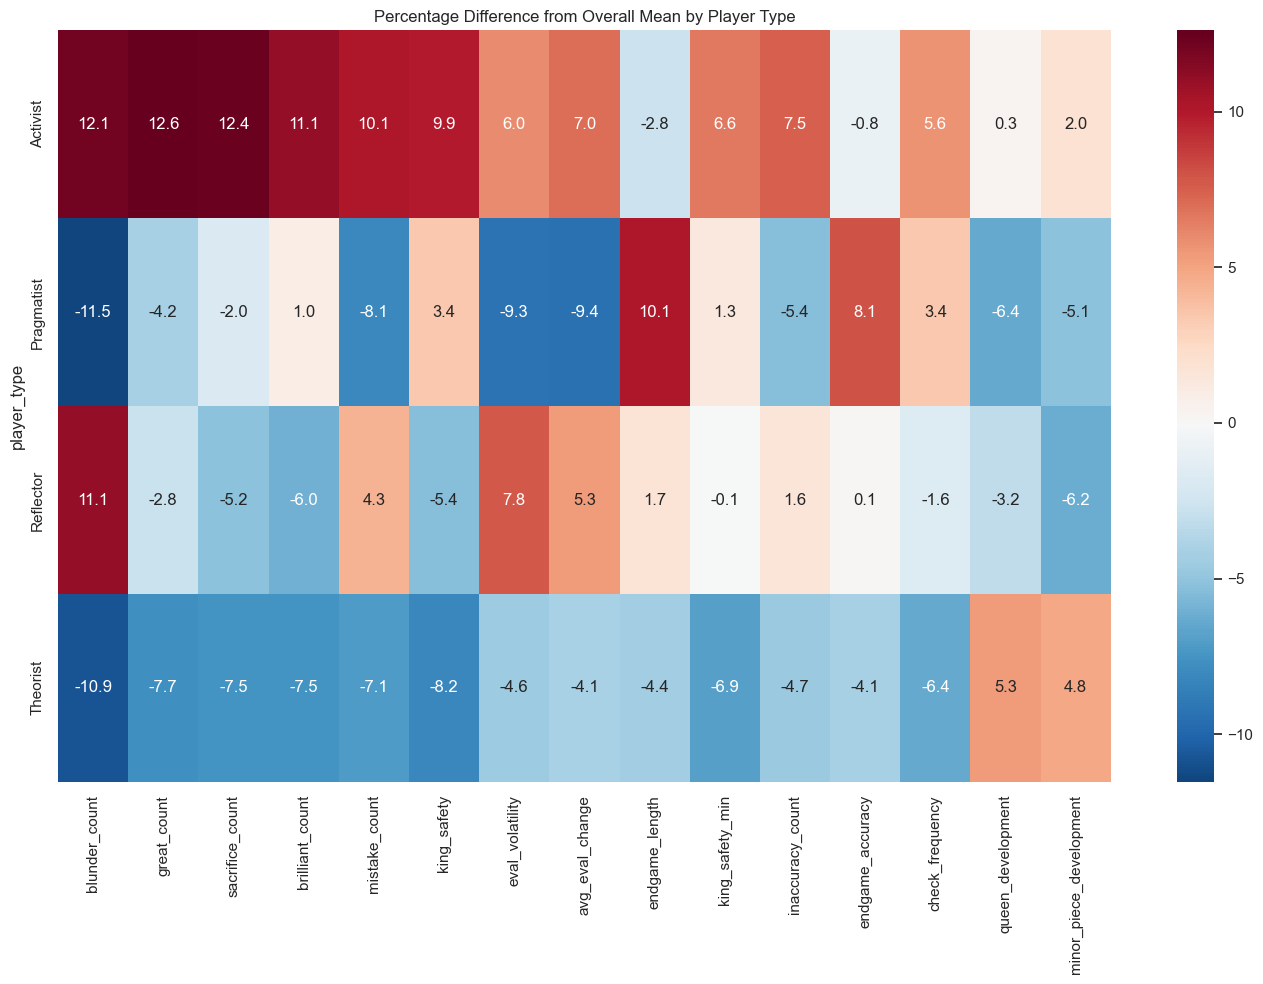


11. PLAYER-LEVEL FEATURE ANALYSIS


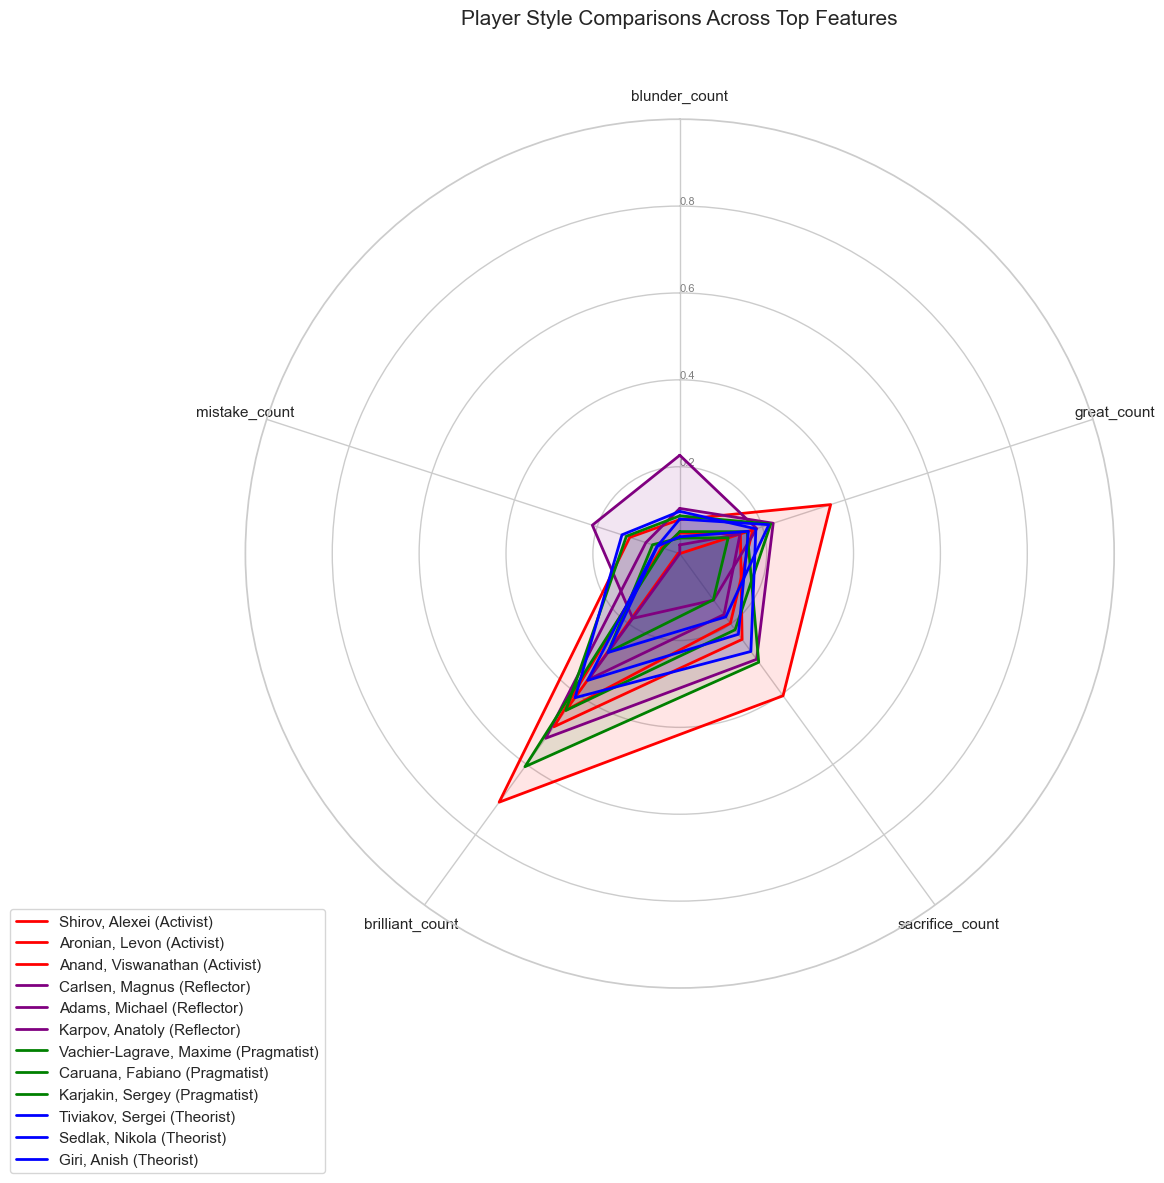


12. FEATURE PATTERNS BY PLAYER TYPE


<Figure size 1600x1200 with 0 Axes>

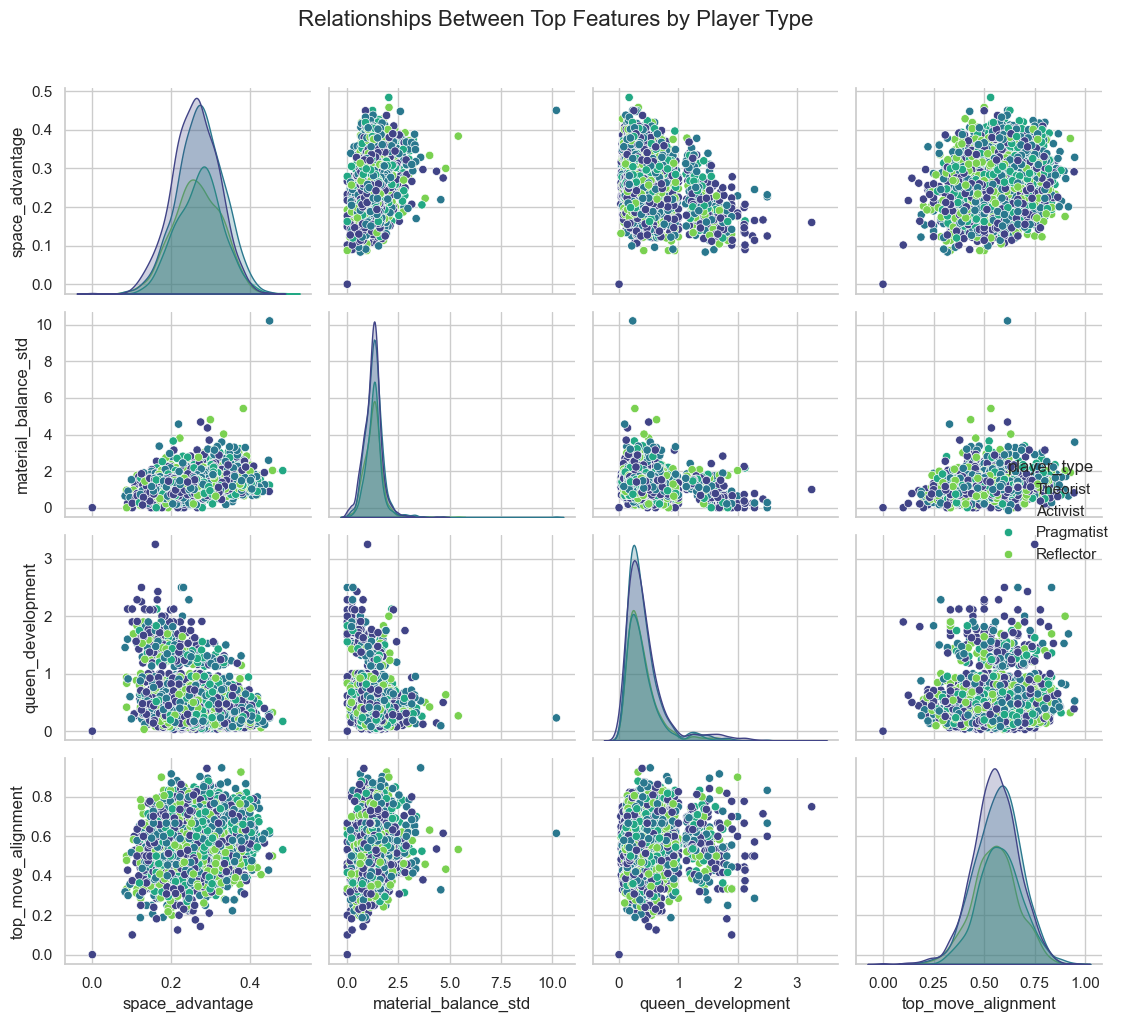


13. PERFORMANCE WITH DIFFERENT FEATURE SETS

Performance comparison with different feature sets:
                        Mean Accuracy   Std Dev  Feature Count
Top 5 ANOVA features         0.318875  0.004557            5.0
Top 5 MI features            0.323255  0.008191            5.0
Top 5 RF features            0.321714  0.005655            5.0
Top 5 overall features       0.319524  0.008163            5.0
All features                 0.350818  0.007084           40.0


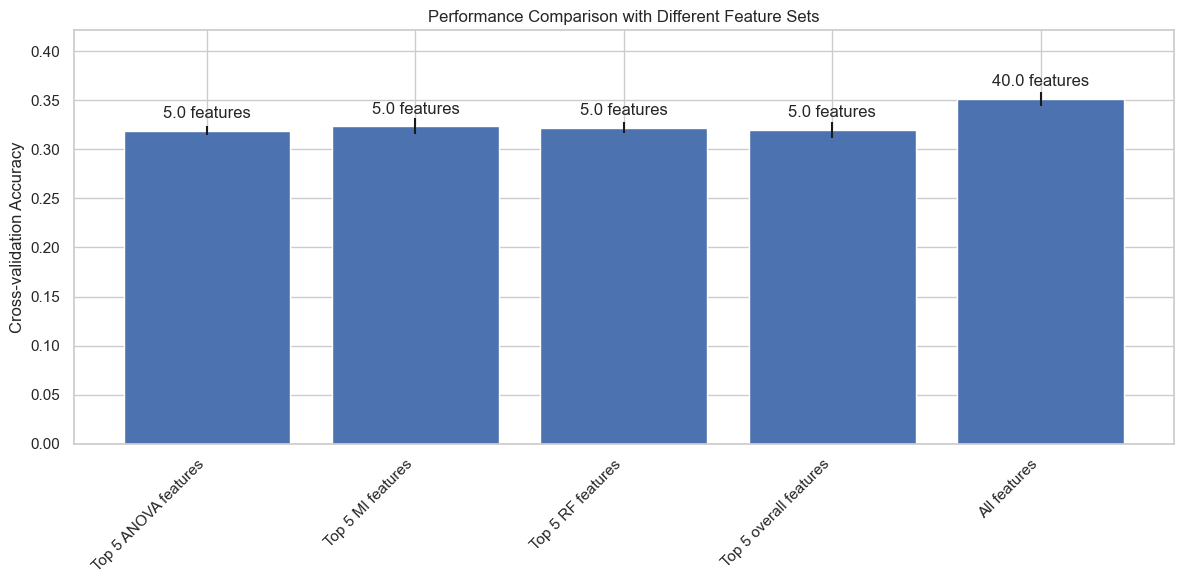


14. SUGGESTED FEATURE TRANSFORMATIONS

Suggested transformations for highly skewed features:
blunder_count: Log transform (skewness = 9.44)
avg_eval_change: Log transform (skewness = 7.56)
king_safety_min: Exponential transform (skewness = -5.13)
eval_volatility: Log transform (skewness = 4.60)
king_safety: Exponential transform (skewness = -4.42)
middlegame_accuracy: Exponential transform (skewness = -3.88)
opening_accuracy: Exponential transform (skewness = -3.72)
minor_piece_development: Log transform (skewness = 3.54)
queen_development: Log transform (skewness = 3.08)
mistake_count: Log transform (skewness = 2.67)

Suggested handling for highly correlated features:
avg_eval_change and eval_volatility (r=0.95): Consider dropping one or creating a composite feature
king_safety and king_safety_min (r=0.84): Consider dropping one or creating a composite feature
material_changes and capture_frequency (r=0.83): Consider dropping one or creating a composite feature
material_volatility an

In [2]:
# Chess Player Feature Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set the plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data
print("Loading data...")
df = pd.read_csv('player_centric_data.csv')
print(f"Dataset shape: {df.shape}")

# Display basic information
print("\nPlayer types distribution:")
print(df['player_type'].value_counts(dropna=False))

# Filter to include only rows with known player types
typed_df = df[df['player_type'].notna()].copy()
print(f"\nDataset with known player types: {typed_df.shape}")

# Define metadata columns (not features)
meta_cols = ['player_name', 'player_color', 'opponent_name', 
            'player_type', 'game_id', 'result', 'date', 
            'eco', 'opening_name', 'player_elo']

# Get feature columns
feature_cols = [col for col in df.columns if col not in meta_cols]
print(f"\nNumber of features: {len(feature_cols)}")

# 1. Basic feature statistics
print("\n1. BASIC FEATURE STATISTICS")
feature_stats = typed_df[feature_cols].describe().T
feature_stats['missing'] = typed_df[feature_cols].isnull().sum()
feature_stats['missing_pct'] = typed_df[feature_cols].isnull().mean() * 100

# Display features with highest missing value percentages
print("\nFeatures with most missing values:")
print(feature_stats.sort_values('missing_pct', ascending=False).head(10)[['missing', 'missing_pct']])

# 2. Feature distributions
print("\n2. FEATURE DISTRIBUTIONS")

# Function to calculate skewness
def calculate_skewness(x):
    return ((x - x.mean()) ** 3).mean() / ((x - x.mean()) ** 2).mean() ** 1.5

# Calculate skewness for each feature
skewness = {col: calculate_skewness(typed_df[col].dropna()) for col in feature_cols}
skewness_df = pd.DataFrame.from_dict(skewness, orient='index', columns=['skewness'])
skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)

print("\nFeatures with highest skewness (potentially need transformation):")
print(skewness_df.head(10))

# Plot distributions of most skewed features
plt.figure(figsize=(16, 10))
for i, feature in enumerate(skewness_df.head(6).index):
    plt.subplot(2, 3, i+1)
    sns.histplot(typed_df[feature].dropna(), kde=True)
    plt.title(f"{feature} (skewness: {skewness_df.loc[feature, 'skewness']:.2f})")
    plt.tight_layout()
plt.show()

# 3. Feature correlations
print("\n3. FEATURE CORRELATIONS")

# Calculate correlation matrix
corr_matrix = typed_df[feature_cols].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:  # Threshold for high correlation
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr_matrix.iloc[i, j]))

# Sort by absolute correlation value
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nHighly correlated feature pairs (|r| > 0.7):")
for pair in high_corr_pairs[:10]:  # Top 10 pairs
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.3f}")

# Plot correlation heatmap for top 15 features
plt.figure(figsize=(14, 12))
top_features = feature_stats.sort_values('std', ascending=False).head(15).index
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Top 15 Features')
plt.tight_layout()
plt.show()

# 4. Feature discriminative power using ANOVA F-value
print("\n4. FEATURE DISCRIMINATIVE POWER")

# Prepare data for feature selection
X = typed_df[feature_cols]
y = typed_df['player_type']

# Handle missing values for feature selection
X_filled = X.fillna(X.mean())

# Calculate ANOVA F-values
f_values, p_values = f_classif(X_filled, y)
f_df = pd.DataFrame({'Feature': feature_cols, 'F-Score': f_values, 'P-Value': p_values})
f_df = f_df.sort_values('F-Score', ascending=False)

print("\nTop 15 features by ANOVA F-score:")
print(f_df.head(15))

# Plot top features by F-score
plt.figure(figsize=(12, 8))
sns.barplot(x='F-Score', y='Feature', data=f_df.head(15))
plt.title('Top 15 Features by ANOVA F-Score')
plt.tight_layout()
plt.show()

# 5. Feature discriminative power using mutual information
print("\n5. MUTUAL INFORMATION ANALYSIS")

# Calculate mutual information scores
mi_scores = mutual_info_classif(X_filled, y)
mi_df = pd.DataFrame({'Feature': feature_cols, 'MI-Score': mi_scores})
mi_df = mi_df.sort_values('MI-Score', ascending=False)

print("\nTop 15 features by Mutual Information:")
print(mi_df.head(15))

# Plot top features by mutual information
plt.figure(figsize=(12, 8))
sns.barplot(x='MI-Score', y='Feature', data=mi_df.head(15))
plt.title('Top 15 Features by Mutual Information')
plt.tight_layout()
plt.show()

# 6. Compare feature rankings between F-score and MI
print("\n6. COMPARING FEATURE RANKINGS")

# Combine rankings
rankings = pd.DataFrame({
    'Feature': feature_cols,
    'F-Score Rank': [list(f_df['Feature']).index(f) + 1 for f in feature_cols],
    'MI Rank': [list(mi_df['Feature']).index(f) + 1 for f in feature_cols]
})
rankings = rankings.sort_values('F-Score Rank')

# Calculate ranking differences
rankings['Rank Difference'] = rankings['F-Score Rank'] - rankings['MI Rank']

# Display features with biggest ranking differences
print("\nFeatures with biggest ranking differences (ANOVA vs Mutual Information):")
print(rankings.sort_values('Rank Difference', key=abs, ascending=False).head(10))

# 7. Feature importance from Random Forest
print("\n7. RANDOM FOREST FEATURE IMPORTANCE")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_filled, y)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 features by Random Forest importance:")
print(importance_df.head(15))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

# 8. Compare all feature rankings
print("\n8. COMPARING ALL FEATURE RANKINGS")

# Create a comprehensive ranking comparison
all_rankings = pd.DataFrame({
    'Feature': feature_cols,
    'F-Score Rank': [list(f_df['Feature']).index(f) + 1 for f in feature_cols],
    'MI Rank': [list(mi_df['Feature']).index(f) + 1 for f in feature_cols],
    'RF Rank': [list(importance_df['Feature']).index(f) + 1 for f in feature_cols]
})

# Calculate average rank
all_rankings['Avg Rank'] = all_rankings[['F-Score Rank', 'MI Rank', 'RF Rank']].mean(axis=1)
all_rankings = all_rankings.sort_values('Avg Rank')

print("\nTop 15 features by average rank across all methods:")
print(all_rankings.head(15))

# 9. Feature distributions by player type
print("\n9. FEATURE DISTRIBUTIONS BY PLAYER TYPE")

# Get top 5 features from average ranking
top_features = all_rankings.head(5)['Feature'].tolist()

# Create boxplots for top 5 features by player type
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='player_type', y=feature, data=typed_df)
    plt.title(f"{feature} by Player Type")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Also create violin plots to better see distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.violinplot(x='player_type', y=feature, data=typed_df)
    plt.title(f"{feature} by Player Type")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Feature mean values by player type
print("\n10. FEATURE MEANS BY PLAYER TYPE")

# Calculate mean values for each feature by player type
player_type_means = typed_df.groupby('player_type')[feature_cols].mean()

# Calculate percentage difference from overall mean for each feature and player type
overall_means = typed_df[feature_cols].mean()
pct_diff = player_type_means.copy()

for col in feature_cols:
    for idx in pct_diff.index:
        if overall_means[col] != 0:
            pct_diff.loc[idx, col] = ((player_type_means.loc[idx, col] - overall_means[col]) / overall_means[col]) * 100
        else:
            pct_diff.loc[idx, col] = 0

# Find features with biggest percentage differences between player types
max_diffs = {}
for col in pct_diff.columns:
    max_diff = pct_diff[col].max() - pct_diff[col].min()
    max_diffs[col] = max_diff

max_diff_df = pd.DataFrame.from_dict(max_diffs, orient='index', columns=['Max % Difference'])
max_diff_df = max_diff_df.sort_values('Max % Difference', ascending=False)

print("\nFeatures with largest percentage differences between player types:")
print(max_diff_df.head(15))

# Plot heatmap of percentage differences for top 15 features with biggest differences
plt.figure(figsize=(14, 10))
top_diff_features = max_diff_df.head(15).index
sns.heatmap(pct_diff[top_diff_features], annot=True, cmap='RdBu_r', fmt='.1f', center=0)
plt.title('Percentage Difference from Overall Mean by Player Type')
plt.tight_layout()
plt.show()

# 11. Player-level feature analysis
print("\n11. PLAYER-LEVEL FEATURE ANALYSIS")

# Group by player_name and calculate mean values
player_means = typed_df.groupby('player_name')[feature_cols].mean()
player_means['player_type'] = typed_df.groupby('player_name')['player_type'].first()

# Select a subset of players for visualization (top 3 players per type)
player_counts = typed_df['player_name'].value_counts()
selected_players = []

for player_type in typed_df['player_type'].unique():
    # Get players of this type with most games
    players_of_type = typed_df[typed_df['player_type'] == player_type]['player_name'].unique()
    players_by_count = sorted(players_of_type, key=lambda p: player_counts.get(p, 0), reverse=True)
    selected_players.extend(players_by_count[:3])

selected_player_means = player_means.loc[selected_players]

# Create a radar chart for selected players using top 5 features
top_radar_features = max_diff_df.head(5).index.tolist()

# Set up the radar chart
def radar_chart(features, players, player_data, player_types):
    # Number of variables
    N = len(features)
    
    # Create angles for each feature
    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    
    # Add each player
    for player in players:
        # Get player data
        values = player_data.loc[player, features].values.tolist()
        # Scale values to 0-1 for radar chart
        values = [(v - player_data[f].min()) / (player_data[f].max() - player_data[f].min()) if 
                 (player_data[f].max() - player_data[f].min()) != 0 else 0.5 for v, f in zip(values, features)]
        values += values[:1]
        
        # Get player type for color
        player_type = player_data.loc[player, 'player_type']
        color = {'Activist': 'red', 'Theorist': 'blue', 'Pragmatist': 'green', 'Reflector': 'purple'}.get(player_type, 'gray')
        
        # Plot player line
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{player} ({player_type})", color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Set labels
    plt.xticks(angles[:-1], features)
    
    # Draw y-axis labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
    plt.ylim(0, 1)
    
    # Add title
    plt.title("Player Style Comparisons Across Top Features", size=15, y=1.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Create the radar chart
radar_chart(top_radar_features, selected_players, player_means, typed_df['player_type'].unique())
plt.tight_layout()
plt.show()

# 12. Feature patterns by player type
print("\n12. FEATURE PATTERNS BY PLAYER TYPE")

# Select top features for pairplot
top_pair_features = all_rankings.head(4)['Feature'].tolist()

# Create a pairplot to visualize relationships
plt.figure(figsize=(16, 12))
pairplot_data = typed_df[top_pair_features + ['player_type']].sample(min(5000, len(typed_df)))  # Limit to 5000 points for speed
sns.pairplot(data=pairplot_data, hue='player_type', palette='viridis', diag_kind='kde')
plt.suptitle('Relationships Between Top Features by Player Type', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# 13. Test set performance with different feature sets
print("\n13. PERFORMANCE WITH DIFFERENT FEATURE SETS")

# Define different feature sets
feature_sets = {
    'Top 5 ANOVA features': f_df.head(5)['Feature'].tolist(),
    'Top 5 MI features': mi_df.head(5)['Feature'].tolist(),
    'Top 5 RF features': importance_df.head(5)['Feature'].tolist(),
    'Top 5 overall features': all_rankings.head(5)['Feature'].tolist(),
    'All features': feature_cols
}

# Compare performance
results = {}
for name, features in feature_sets.items():
    X_subset = X_filled[features]
    
    # Use cross-validation to evaluate
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(rf, X_subset, y, cv=5)
    
    results[name] = {
        'Mean Accuracy': scores.mean(),
        'Std Dev': scores.std(),
        'Feature Count': len(features)
    }

results_df = pd.DataFrame(results).T
print("\nPerformance comparison with different feature sets:")
print(results_df)

# Plot performance comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(results_df.index, results_df['Mean Accuracy'], yerr=results_df['Std Dev'])
plt.ylabel('Cross-validation Accuracy')
plt.title('Performance Comparison with Different Feature Sets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(results_df['Mean Accuracy']) * 1.2)

# Add feature counts as text on bars
for i, bar in enumerate(bars):
    feature_count = results_df.iloc[i]['Feature Count']
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f"{feature_count} features", ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# 14. Suggest feature transformations
print("\n14. SUGGESTED FEATURE TRANSFORMATIONS")

# For skewed features
print("\nSuggested transformations for highly skewed features:")
for feature, skew in skewness_df.head(10).iterrows():
    skew_value = skew['skewness']
    if skew_value > 1.5:
        print(f"{feature}: Log transform (skewness = {skew_value:.2f})")
    elif skew_value < -1.5:
        print(f"{feature}: Exponential transform (skewness = {skew_value:.2f})")
    elif skew_value > 0.5:
        print(f"{feature}: Square root transform (skewness = {skew_value:.2f})")
    elif skew_value < -0.5:
        print(f"{feature}: Square transform (skewness = {skew_value:.2f})")

# For correlated features
print("\nSuggested handling for highly correlated features:")
for f1, f2, corr in high_corr_pairs[:5]:
    if corr > 0:
        print(f"{f1} and {f2} (r={corr:.2f}): Consider dropping one or creating a composite feature")
    else:
        print(f"{f1} and {f2} (r={corr:.2f}): Consider creating a ratio or difference feature")

# 15. Suggest new composite features
print("\n15. SUGGESTED NEW COMPOSITE FEATURES")

# Based on domain knowledge and feature analysis
composite_suggestions = [
    ("tactical_vs_positional", "tactical_score / positional_score", "Ratio of tactical to positional play"),
    ("opening_vs_endgame", "opening_length / endgame_length", "Balance between opening and endgame focus"),
    ("dynamic_play_index", "(material_changes / total_moves) * sharpness", "Measure of dynamic play style"),
    ("calculation_intensity", "top_move_alignment * (1 - blunder_count)", "Measure of calculation accuracy"),
    ("time_phase_balance", "abs(opening_length - endgame_length)", "Preference for certain game phases"),
    ("theoretical_originality", "opening_novelty_score * (1 - top_move_alignment)", "Creative approach to openings"),
    ("positional_understanding", "space_advantage * center_control_avg", "Understanding of positional concepts")
]

print("\nSuggested composite features to better discriminate player styles:")
for name, formula, description in composite_suggestions:
    print(f"- {name}: {formula}\n  {description}")

print("\nFeature analysis complete!")